<a href="https://colab.research.google.com/github/AgusLuigi/retail_demand_analysis/blob/main/Python_Zeitrheie_analyse_Fallstudie2_nutzung_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Schritt 0: Darts installieren


In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.3 MB/s eta 0:00:00


# Schritt 1: Laden einer einzelnen Store-Artikelserie

 Wir verwenden erneut die Verkaufszeitreihendaten aus dem Datensatz „Corporación Favorita Grocery Sales Forecasting“.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import gdown

# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

def read_metadata_files(file_ids):
  # Read all files but train.csv
  # Load each CSV using the helper functions
  df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
  df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
  df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
  df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
  df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
  return df_holiday_events, df_items, df_oil, df_stores, df_transactions

# Dictionary of file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events, df_items, df_oil, df_stores, df_transactions = read_metadata_files(file_ids)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kopieren Sie Ihre Helfer zum Lesen und Laden von Dateien aus Woche 1 und fügen Sie dann einen Filter für store_nbr, item_nbr, und date < '2014-04-01'hinzu. Das Ergebnis ist ein übersichtlicher DataFrame mit nur den täglichen Verkäufen für unsere ausgewählte Serie.


In [ ]:
# Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

# Load stores and get Pichincha store IDs
stores_url = make_drive_url(file_ids["stores"])
df_stores = pd.read_csv(io.StringIO(requests.get(stores_url).text))
store_ids = df_stores[df_stores['state'] == 'Pichincha']['store_nbr'].unique()

# NEW!
# Let's filter the data for one store and one item to keep it simple
store_ids = [44]
item_ids = [1047679]
#Select data before April'14
max_date = '2014-04-01'

# Read train.csv in chunks and filter for Pichincha region
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    # DtypeWarning aufgrund gemischter Typen in Spalte 5 (oft 'perishable') wird hier ignoriert.
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    filtered_chunks.append(chunk_filtered)
    del chunk

# Kombiniere die gefilterten Chunks
df_train = pd.concat(filtered_chunks, ignore_index=True)
del filtered_chunks

# NEUER ABSCHNITT: Sichere Stichprobennahme
population_size = len(df_train)
target_sample_size = 2_000_000
random_state_seed = 42

print(f"Gefilterte Bevölkerungsgröße (Anzahl der Zeilen nach Filterung): {population_size}")
print(f"Zielstichprobengröße: {target_sample_size}")

if population_size == 0:
    print("Die gefilterten Daten enthalten keine Zeilen. Die Stichprobe kann nicht durchgeführt werden.")
elif population_size <= target_sample_size:
    # Wenn die Population kleiner oder gleich der Zielgröße ist, behalten wir alle Zeilen
    print(f"Die gefilterten Daten ({population_size} Zeilen) werden vollständig verwendet (keine Stichprobe erforderlich).")
else:
    # Wenn die Population größer ist, ziehen wir die Zielstichprobe
    print(f"Die gefilterten Daten sind groß genug. Es wird eine Stichprobe von {target_sample_size} Zeilen genommen.")
    df_train = df_train.sample(n=target_sample_size, random_state=random_state_seed)

# Index zurücksetzen
df_train = df_train.reset_index(drop=True)

# Ausgabe der finalen Größe zur Bestätigung
print(f"Finale Größe des train DataFrames: {len(df_train)} Zeilen")


Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=52ab7dca-980e-4908-85d2-0f168f6d73ed
To: /content/train.csv
100%|██████████| 5.00G/5.00G [01:13<00:00, 68.3MB/s]
/tmp/ipython-input-1572629190.py:21: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv("train.csv", chunksize=chunk_size):


Gefilterte Bevölkerungsgröße (Anzahl der Zeilen nach Filterung): 452
Zielstichprobengröße: 2000000
Die gefilterten Daten (452 Zeilen) werden vollständig verwendet (keine Stichprobe erforderlich).
Finale Größe des train DataFrames: 452 Zeilen


In [ ]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
df_train.head()


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,33412,2013-01-02,44,1047679,582.0,NaN
1,73815,2013-01-03,44,1047679,310.0,NaN
2,113679,2013-01-04,44,1047679,338.0,NaN
3,155808,2013-01-05,44,1047679,654.0,NaN
4,197767,2013-01-06,44,1047679,979.0,NaN


# Schritt 2: Vorbereiten und in Zeitreihen konvertieren
- Konvertieren Sie es datein datetimeund legen Sie es als Index fest.
- Aggregieren nach Datum (Summierung aller Stückverkäufe für diesen Tag).
- Indizieren Sie den Kalender neu, um ihn vollständig zu machen, und füllen Sie alle Lücken mit Nullen.
- Abschließend binden Sie es in das Darts- TimeSeriesObjekt ein, damit alle Modellierungs- und Backtesting-Tools der Bibliothek sofort einsatzbereit sind.


In [ ]:
# Hinzufügen der notwendigen Imports
import pandas as pd
from darts import TimeSeries

# Initialisierung von df_filtered (Voraussetzung: df_train existiert)
df_filtered = df_train.copy()

# 1. Datumskonvertierung
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# 2. Gruppierung und Aggregation
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# 3. Setzen des Index
df_filtered.set_index('date', inplace=True)

# 4. Auffüllen fehlender Datenpunkte (Resampling)
df_filtered = df_filtered.asfreq('D').fillna(0)

# 5. Konvertierung in Darts TimeSeries Objekt
series = TimeSeries.from_dataframe(df_filtered, value_cols='unit_sales')

<Axes: xlabel='date'>

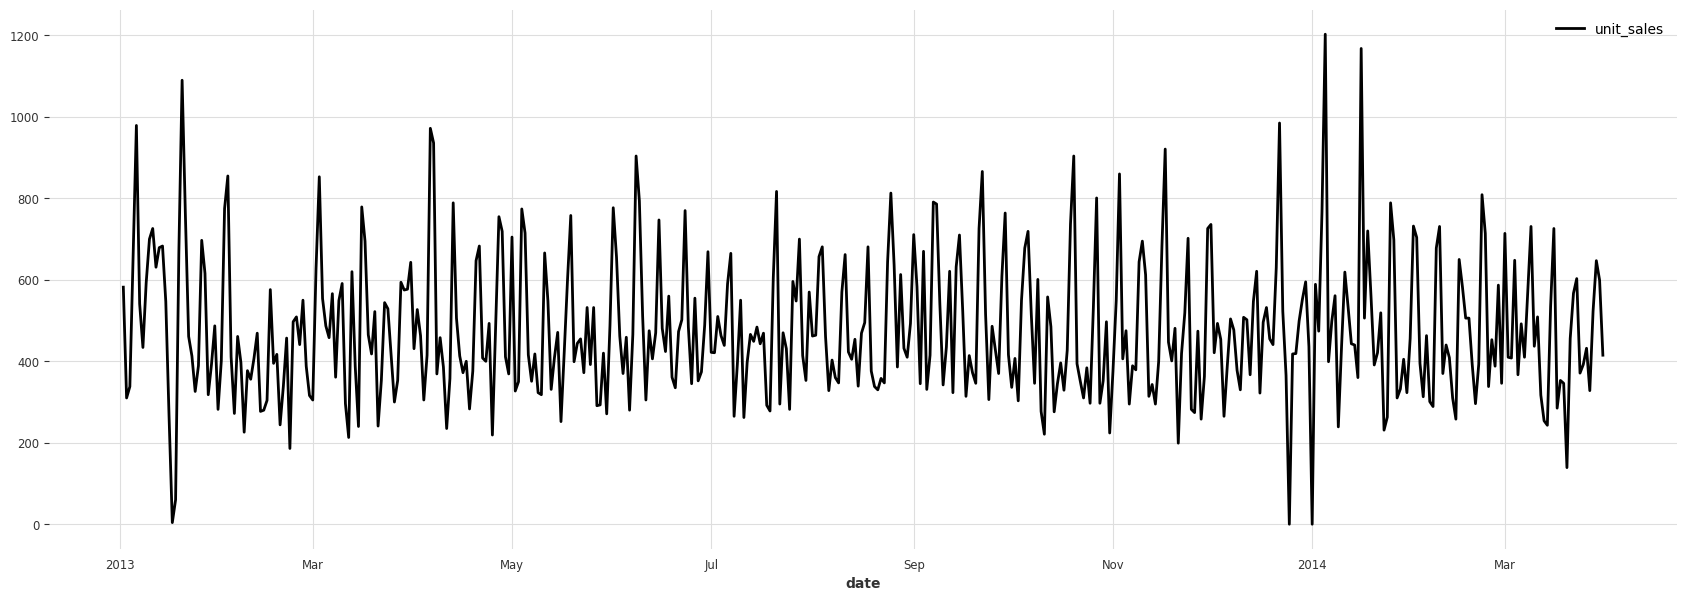

In [ ]:
# Visualize the filtered sales data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
series.plot()

- Was fällt Ihnen am Verkaufsvolumen auf? Ist es konstant, volatil oder tendiert es?
- Folgen die Spitzen einem sichtbaren Muster?
- Welche Arten von Merkmalen könnten dem Modell dabei helfen, dieses Verhalten zu erfassen?

## Wichtige Beobachtungen
- Die Verkaufszahlen sind konstant hoch : Das Produkt wird täglich verkauft, normalerweise zwischen 300 und 800 Stück , mit einigen Spitzen von über 1.000 Stück . Es handelt sich also um einen Massenartikel .
- Keine fehlenden oder Nullwerte : Wir sehen jeden Tag Aktivität, was beim Trainieren eines Modells nützlich ist, das aus historischem Verhalten lernt.
- Häufige, starke Schwankungen : Die Reihe ist unruhig – sie schwankt regelmäßig auf und ab – aber meist innerhalb eines vorhersehbaren Bereichs.
- Gelegentlich große Spitzen : Einige Spitzen liegen deutlich über dem üblichen Verkaufsbereich, was auf Werbeaktionen, Feiertage oder besondere Ereignisse zurückzuführen sein kann.

## Was dies für die Prognose bedeutet
- Das Modell profitiert von Verzögerungsmerkmalen (z. B. sales_lag_1, rolling_mean_7), um lokale Dynamiken zu erlernen.
- Möglicherweise möchten Sie Kalenderfunktionen wie day_of_week, is_weekend, oder einbinden month, um wiederkehrende Muster besser erfassen zu können.
- Um die Volatilität besser zu handhaben, kann die Anwendung eines gleitenden Durchschnitts oder die Verwendung einer Log-Transformation die Modellstabilität verbessern.
- Um gelegentliche Spitzen genauer vorherzusagen, wäre es sinnvoll , externe Signale wie Werbeaktionen (sofern verfügbar) hinzuzufügen.

# Schritt 3: Aufteilen der Daten in Trainings- und Testsätze


In [ ]:
# Split the data (80% training, 20% testing)
train, test = series.split_after(0.8)

Dadurch werden die letzten 20 % Ihrer Daten als Testdatensatz reserviert

# Klassische Zeitreihenmethoden: ARIMA & Parameter d


Autoregression (AR )
Integration (I)
Gleitender Durchschnitt (MA)

Um das ARIMA-Modell verwenden zu können, müssen wir drei Parameter definieren, die das Modell verwenden wird: die p-, d- und q-Werte. Jeder bezieht sich auf einen der oben genannten Schritte.


Schritt 1. Beginnen Sie ohne Differenzierung (d = 0)

<Axes: title={'center': 'Raw unit_sales (d=0)'}, xlabel='date'>

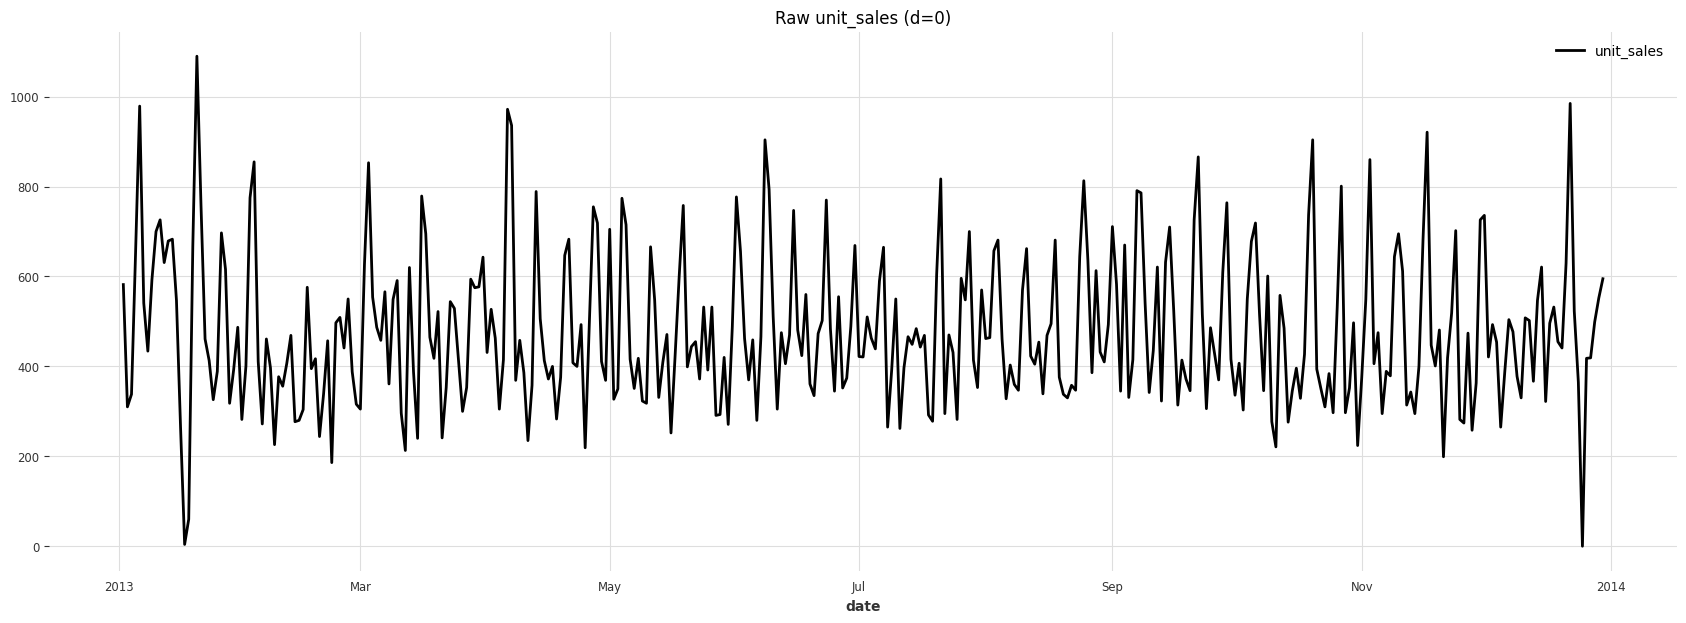

In [ ]:
plt.figure(figsize=(21, 7))
train.plot(title="Raw unit_sales (d=0)")

# Erst denken!
Welche Muster oder „Drifts“ bemerken Sie im Laufe der Zeit?
Sieht es so aus, als ob der Durchschnittswert ungefähr konstant bleibt oder gibt es einen Auf-/Abwärtstrend?
Würden Sie diese Serie aufgrund Ihres optischen Eindrucks als „stationär“ bezeichnen?

## 1. Visuelle Muster und Drift
- Die Reihe weist über den gesamten Zeitraum hinweg starke kurzfristige Schwankungen auf .
- Es gibt keinen klaren langfristigen Aufwärts- oder Abwärtstrend , aber:
  - Die Amplitude (Ausbreitung) des Rauschens scheint sich im Laufe des Jahres leicht zu ändern.
  - Zu Beginn der Serie (Januar–März) beobachten wir mehrere extreme Spitzen – sowohl Hochs als auch Tiefs – die später weniger ausgeprägt sind.
  - Es kann zu leichten Saisonalitäten oder Abweichungen kommen , diese sind jedoch nicht stark richtungsweisend.
## 2. Mittlerer Pegel: Konstant oder veränderlich?
- Der Durchschnittswert scheint bei etwa 500–600 Einheiten/Tag ziemlich stabil zu sein.
- Es gibt keinen offensichtlichen Trend zu steigenden oder sinkenden durchschnittlichen Umsätzen im Laufe der Zeit.
- Abgesehen von geringfügigen Änderungen der Variabilität bleibt das zentrale Niveau stabil, was auf eine mittlere Stationarität hindeutet .
## 3. Stationaritätsbewertung (visuell)
- Aus visueller Sicht ist diese Reihe wahrscheinlich schwach stationär , weil:
  - Der Mittelwert ist ungefähr konstant
  - Die Varianz ist im Laufe der Zeit relativ konstant (obwohl sie zu Beginn etwas unruhiger ist).
  - Es ist kein starker Trend oder Saisonalität erkennbar
- Es gibt jedoch gelegentlich Ausreißer oder Strukturbrüche (z. B. plötzliche Einbrüche auf Null), die statistische Stationaritätstests wie den ADF-Test beeinträchtigen können.


## Abschluss
Diese Reihe erscheint optisch stationär oder zumindest nahe genug, damit viele Prognosemodelle ohne Differenzbildung (d=0) gut funktionieren .

# Visuelle Kontrolle: rollender Mittelwert


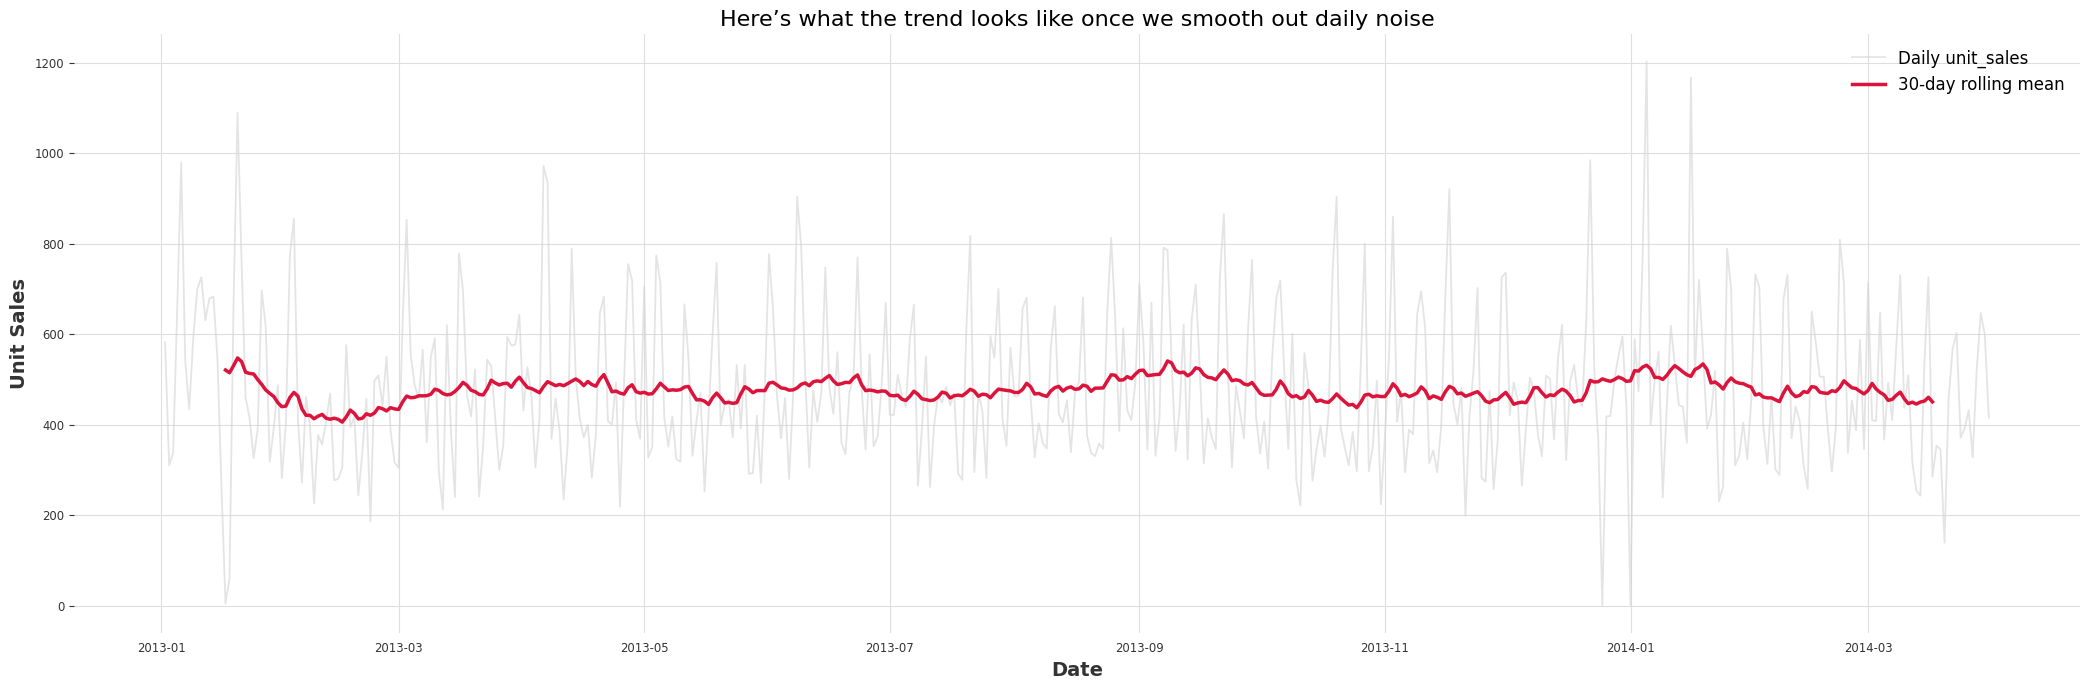

In [ ]:

import matplotlib.pyplot as plt


# Compute a 30-day rolling average to smooth out the daily noise
rolling_trend = df_filtered['unit_sales'].rolling(window=30, center=True).mean()

plt.figure(figsize=(21, 7))
# Plot the raw daily sales in light gray
plt.plot(df_filtered.index, df_filtered['unit_sales'],
         color='lightgray', alpha=0.6, label='Daily unit_sales')
# Overlay the 30-day rolling mean in a bold color
plt.plot(rolling_trend.index, rolling_trend.values,
         color='crimson', linewidth=2.5, label='30-day rolling mean')

plt.title("Here’s what the trend looks like once we smooth out daily noise", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Unit Sales", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

- Welche Muster oder „Drifts“ bemerken Sie im Laufe der Zeit?
- Sieht es so aus, als ob der Durchschnittswert ungefähr konstant bleibt oder gibt es einen Auf-/Abwärtstrend?
- Würden Sie diese Serie aufgrund Ihres optischen Eindrucks als „stationär“ bezeichnen?

  - Drift : Anfang 2013 gibt es einen Abwärtstrend , aber nach März stabilisiert sich die Serie.
  - Mittlerer Wert : Insgesamt nicht konstant – er sinkt zunächst und bleibt dann bei etwa 430–480 Einheiten/Tag.
  - Stationarität : Die gesamte Zeitreihe ist nicht vollkommen stationär , aber nach dem anfänglichen Rückgang weitgehend stabil . Für viele Prognosemodelle kann sie als nahezu stationär betrachtet werden .  

# Stat-Test

In [ ]:
# ADF-Test
from statsmodels.tsa.stattools import adfuller

# adfuller() doesn’t know how to handle a Darts TimeSeries object directly
# a) extract the raw values as a NumPy array
#     `train.values()` returns an array of shape (n_timesteps, n_dims)
arr = train.values().flatten()   # flatten to 1-d if it's uni-variate

# b) call adfuller on that array
adf_statistic, p_value, num_lags, num_obs, critical_values, max_lag_used = adfuller(arr)
# Die zusätzlichen Werte werden dadurch in eine Liste 'rest' gepackt, aber hier ignoriert.
print(f"ADF p-value: {p_value}")

ADF p-value: 0.00046708453453955947


## Entscheidung
Wenn p ≥ 0,05 ist  oder Sie einen wichtigen Trend erkennen, wechseln Sie zu d=1.

- Ein niedriger ADF-p-Wert (<0,05) bedeutet technisch gesehen: „Verwerfen Sie die Einheitswurzel-Nullhypothese → die Reihe ist stationär.“ Da unser p-Wert sehr klein ist (≪ 0,05) , können Sie die Nullhypothese mit hoher Sicherheit verwerfen und müssen die Reihe (d=0) für Modelle wie ARIMA nicht differenzieren.
- Aber auch wenn Sie bei d=0 einen winzigen p-Wert erhalten haben, werden wir es bei d=1 versuchen, um Ihnen zu zeigen, wie es geht, falls Sie eine Reihe erhalten, die differenziert werden muss.

# Auswahl von „d“ – Schritt 2

Denken Sie daran: Das „d“ in ARIMA(p,d,q) gibt an, wie oft die Differenzierung der Reihen erfolgen muss, um einen Trend zu entfernen und Stationarität (konstanter Mittelwert und Varianz) zu erreichen.

## Schritt 2. Wenn nicht stationär, versuchen Sie einen Unterschied (d = 1)

🎯 Zweck des Differencing
Das Ziel des Differencing ist es, eine nicht-stationäre Zeitreihe in eine stationäre Reihe umzuwandeln. Durch das Entfernen des Trends (oder der Steigung) und der Saisonalität schwankt die neue Reihe diff1 um einen konstanten Mittelwert (oft Null), was eine Voraussetzung für viele statistische Zeitreihenmodelle (wie ARIMA) ist.
$$\text{diff1}[t] = \text{arr}[t] - \text{arr}[t-1]$$

In [ ]:
# Hinzufügen des NumPy Imports
import numpy as np
# do the 1st difference, this would be our new differenced train data
diff1 = np.diff(arr,1)

<Axes: title={'center': 'unit_sales (d=1)'}>

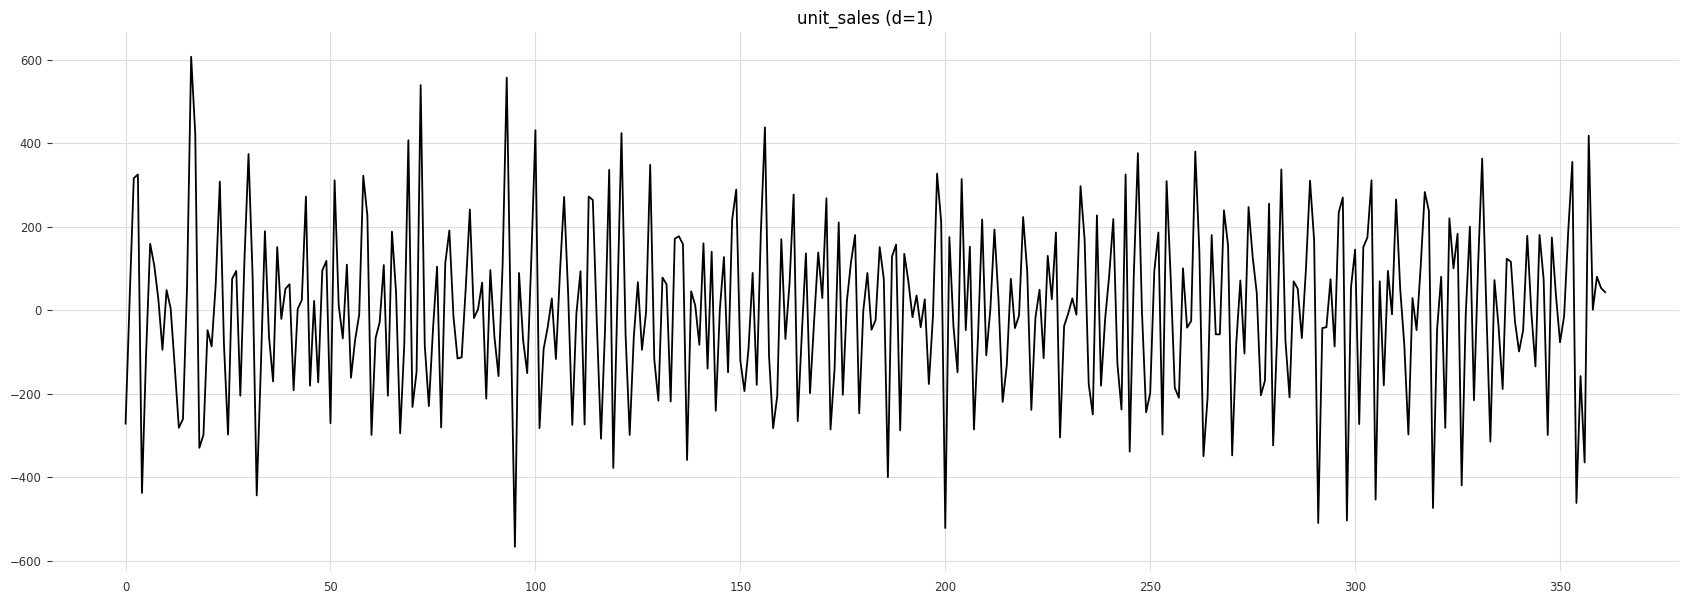

In [ ]:
import pandas as pd

plt.figure(figsize=(21, 7))
pd.Series(diff1).plot(title="unit_sales (d=1)")

In [ ]:
# ADF on the differenced
adf_statistic, p_value, num_lags, num_obs, critical_values, max_lag_used = adfuller(diff1)
print("1st-difference ADF p-value:", p_value)


1st-difference ADF p-value: 2.5893585918459893e-12


- was uns das sagt
  - Visuell: Die Reihe schwankt jetzt um einen ungefähr konstanten Mittelpunkt (kein offensichtlicher Trend).
  - Der ADF-p-Wert bleibt unter 0,05, was die Stationarität nach einer Differenzbildung bestätigt.

📌
- Nur wenn nötig, versuchen Sie zwei Unterschiede (d = 2)
  - Wenn immer noch nicht stationär und der p-Wert > 0,05 ist, können Sie d = 2 akzeptieren – dies kommt jedoch selten vor .
  - Vorsicht: Übermäßige Differenzierung kann zu zusätzlichem Rauschen führen und Ihre Prognose beeinträchtigen.


## 💡Übung

Für das gleiche Geschäft, aber einen anderen Artikel ( 103665 ), führen Sie die gleichen Schritte aus und entscheiden Sie sich für d.

---

# Auswahl von „d“ – Zusammenfassung
- Zusammenfassung: Auswahl von „d“ (Anzahl der Unterschiede) für ARIMA(p, d, q)
  - Verstehen Sie das Ziel. Durch die
Differenzbildung werden Trends entfernt, sodass Ihre Reihe einen ungefähr konstanten Mittelwert (Stationarität) aufweist, was ARIMA voraussetzt.
  - Beginnen Sie ohne Differenzierung (d = 0)
    - Visuelle Überprüfung : Zeichnen Sie die Rohdatenreihe. Schwankt sie im Laufe der Zeit nach oben oder unten (Drift) oder verharren ihre Spitzen und Täler auf demselben Niveau? Wenn Sie unsicher sind, zeichnen Sie den gleitenden Mittelwert auf.
    - Statistische Überprüfung : Führen Sie einen Augmented Dickey–Fuller (ADF)-Test mit den Trainingsdaten durch. Wenn der p-Wert < 0,05 ist und das Diagramm flach aussieht, können Sie hier aufhören (d = 0).
- Wenn immer noch nicht stationär, wenden Sie eine Differenz an (d = 1).
  - Berechnen Sie die erste Differenz:

---
arr = train_series.values().flatten()           # raw values
diff1 = np.diff(arr, n=1)                       # 1st difference

---

  - Visuelle Überprüfung : In ein pd.Series(diff1)Diagramm einbinden – oszilliert es jetzt ohne deutliche Abweichung um Null?
  - Statistische Prüfung : ADF ein diff1. Wenn der p-Wert < 0,05 ist und das Diagramm stationär erscheint, akzeptieren Sie d = 1.
- (Selten) Versuchen Sie zwei Unterschiede (d = 2)
  - Nur wenn d = 1 bleibt noch eine sichtbare Drift (p-Wert ≥ 0,05), Unterschied wieder: diff2 = np.diff(arr, n=2).
  - Vorsicht: Übermäßige Differenzierung kann zu übermäßigem Rauschen führen und die Prognosen verschlechtern.
- Gleichen Sie visuelle und statistische Beweise aus
  - Ein niedriger ADF-p-Wert allein garantiert keine Stationarität, wenn Ihre Reihe immer noch offensichtliche Trends oder eine sich ändernde Varianz aufweist.
  - Verknüpfen Sie das Testergebnis immer mit einem kurzen Diagramm. Wenn Geschäftsentscheidungen von der Drift abhängen, kann selbst ein „stationärer“ p-Wert Sie in die Irre führen.
- Sperre „d“
  - Verwenden Sie das kleinste d, das eine Reihe mit konstantem Mittelwert/Varianz ergibt (normalerweise 0 oder 1).
  - Dokumentieren Sie Ihre Wahl, bevor Sie die autoregressiven (p) und gleitenden Durchschnittsreihenfolgen (q) anpassen.

# ARIMA- AutoRegressiver Teil: AR (p)

# Auswahl von „p“ – Wie viele vergangene Werte sollen einbezogen werden (AR-Reihenfolge)

## Schritt 0. Zuerst die Differenz (falls erforderlich)

das wurde in den Letzten schriten getan und haben uns für 0 endschieden da der wert.
 - ADF p-value: 0.00046708453453955947

# Schritt 1. Zeichnen Sie die partielle Autokorrelationsfunktion (PACF)

Die partielle Autokorrelationsfunktion (PACF) gibt an, wie stark der heutige Wert direkt mit einem bestimmten vorherigen Tag verknüpft ist – nachdem der Einfluss aller dazwischenliegenden Tage entfernt wurde.

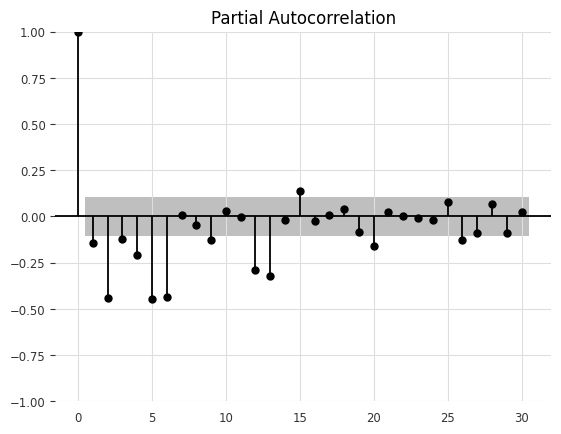

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
# p = 1
diffed_series = diff1.copy()
# lags=30 shows correlations up to 30 past days (≈1 month), helping identify how far back autocorrelations persist.
plot_pacf(diffed_series, lags=30)
plt.show()

- So interpretieren Sie das PACF-Diagramm
  - Balken: Stärke der „direkten“ Verbindung zwischen dem heutigen Tag und dieser Verzögerung, wobei:
    - Y-Achse : Stärke der partiellen Autokorrelation (von –1 bis +1)
    - X-Achse : Verzögerungszahl (wie viele Zeitschritte zurück)
    - Punkte : Die partielle Korrelation bei jeder Verzögerung (z. B. Verzögerung 1, Verzögerung 2, ...)
  - Schattierter Bereich : Konfidenzintervall (normalerweise 95 %). Liegt ein Balken außerhalb des schattierten Bereichs , ist er statistisch signifikant .
  - Erster Takt innerhalb des Bandes: wo die nützliche Erinnerung aufhört.

- Was wir in unserer Handlung sehen
  - Lag 0 zeigt immer eine Korrelation von 1,0, da eine Reihe perfekt mit sich selbst korreliert ist.
  - Ab Verzögerung 1 sehen wir eine starke positive Korrelation, die in vielen Zeitreihen zu erwarten ist – aktuelle Werte lassen oft einen hohen Vorhersagewert für die nächsten Werte zu.
  - Nach Verzögerung 1 zeigen mehrere frühe Verzögerungen (bis Verzögerung 6) signifikante negative partielle Autokorrelationen (außerhalb des grauen Konfidenzintervalls).
  - Die meisten Verzögerungen nach 10 liegen innerhalb der Konfidenzgrenzen , was darauf hinweist, dass ihre partiellen Korrelationen statistisch nicht signifikant sind.

# Schritt 2. Suchen Sie nach dem „Cut-off“
  - Suchen Sie, wo die Balken in das graue Band eintauchen, und bleiben Sie dort.
    - Diese erste „innere“ Verzögerung ist Ihr Cut-off .
  - Stellen Sie p auf diesen Grenzwert (oder etwas niedriger) ein .
    - Wenn nur Lag 1 groß ist → p = 1
    - Wenn die Verzögerungen 1–3 hervorstehen, dann abflachen → p ≈ 3 (Sie können aber p=1-3 ausprobieren und das Beste auswählen )
    - Wenn die Verzögerungen 1–5 über dem Band liegen → p ≈ 5 (Sie können jedoch p=1-5 ausprobieren und das Beste auswählen)

# Schritt 3. Lassen Sie die Daten entscheiden
- Passen Sie Kandidatenmodelle an (ARIMA(p, d, q) mit p aus Schritt 3).
- Vergleichen Sie AIC/BIC oder Validierungsfehler ( wir werden bald mehr darüber erfahren).
- Wählen Sie das Modell mit dem geringsten Fehler.


## 💡Übung
Für das gleiche Geschäft, aber einen anderen Artikel ( 103665 ), folgen Sie den gleichen Schritten und entscheiden Sie sich auf S.

---

# Auswahl von „p“ – Zusammenfassung


- Frage
  - Schnelle Antwort
- Warum nicht ein großes P wählen?
  - Fügt Rauschen und Überanpassungen hinzu; größer ist nicht besser.
- Was ist, wenn ich über dem Band keine Balken sehe?
  - Die Differenzbildung ist möglicherweise zu stark abgeflacht. Versuchen Sie es mit einem kleineren d oder akzeptieren Sie p = 0.
- Was wäre, wenn die Balken nie fallen würden?
  - Wahrscheinlich immer noch nicht stationär – überprüfen Sie die Differenzierung/Saisonalität erneut.

# ARIMA- Gleitender Durchschnitt: MA (q)

Das „q“ in ARIMA(p, d, q) legt fest, wie viele vergangene Prognosefehler das Modell „merken“ soll.

## Schritt 0. Zuerst die Differenz (falls erforderlich)
Machen Sie die Reihe ungefähr flach (stationär), damit der ACF nicht durch Trends/Saisonalität verwirrt wird.
  - Dies haben wir beim Ermitteln von d getan. Die differenzierte Reihe ist diejenige, die wir in den nächsten Schritten verwenden werden.

## Schritt 1. Zeichnen Sie die Autokorrelationsfunktion (ACF)


Die Autokorrelationsfunktion (ACF) misst, wie der heutige Wert mit allen vorherigen Tagen zusammenhängt – direkt und indirekt .

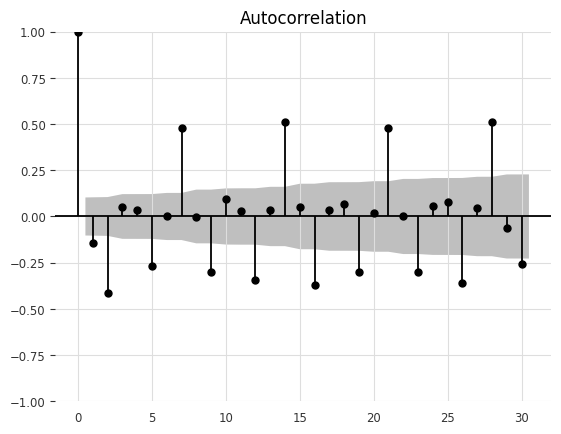

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(diffed_series, lags=30) # lags=30 = how far back we look
plt.show()

## Schritt 2. Lesen Sie die Handlung und wählen Sie q

- Faustregel: Wenn die ACF bei Verzögerung 1 nur eine einzige signifikante Spitze aufweist und darüber hinaus nichts, ist ein MA(1)-Term normalerweise ausreichend. Testen Sie ARIMA-Modelle mit q = 1 (und möglicherweise q = 0 oder 2 als Benchmark) und wählen Sie das beste über AIC/BIC oder den Validierungsfehler aus.

Nicht-saisonale MA-Reihenfolge ( q) – Nach Lag 1 gibt es keinen starken Abfall, aber ein kleiner MA-Zeitraum kann das tägliche Rauschen noch immer ausgleichen. Beginnen Sie mit q = 0, 1und lassen Sie AIC/BIC den Gewinner auswählen.

##💡Übung
Für das gleiche Geschäft, aber einen anderen Artikel ( 103665 ), führen Sie die gleichen Schritte aus und entscheiden Sie sich für 1.

---

# ARIMA-Modelltraining


## Schritt 1: Kandidatenmodelle ARIMA(p, d, q) anpassen und vorhersagen

Wir beginnen mit ARIMA(p = 6, d = 0, q = 1)


<Axes: xlabel='date'>

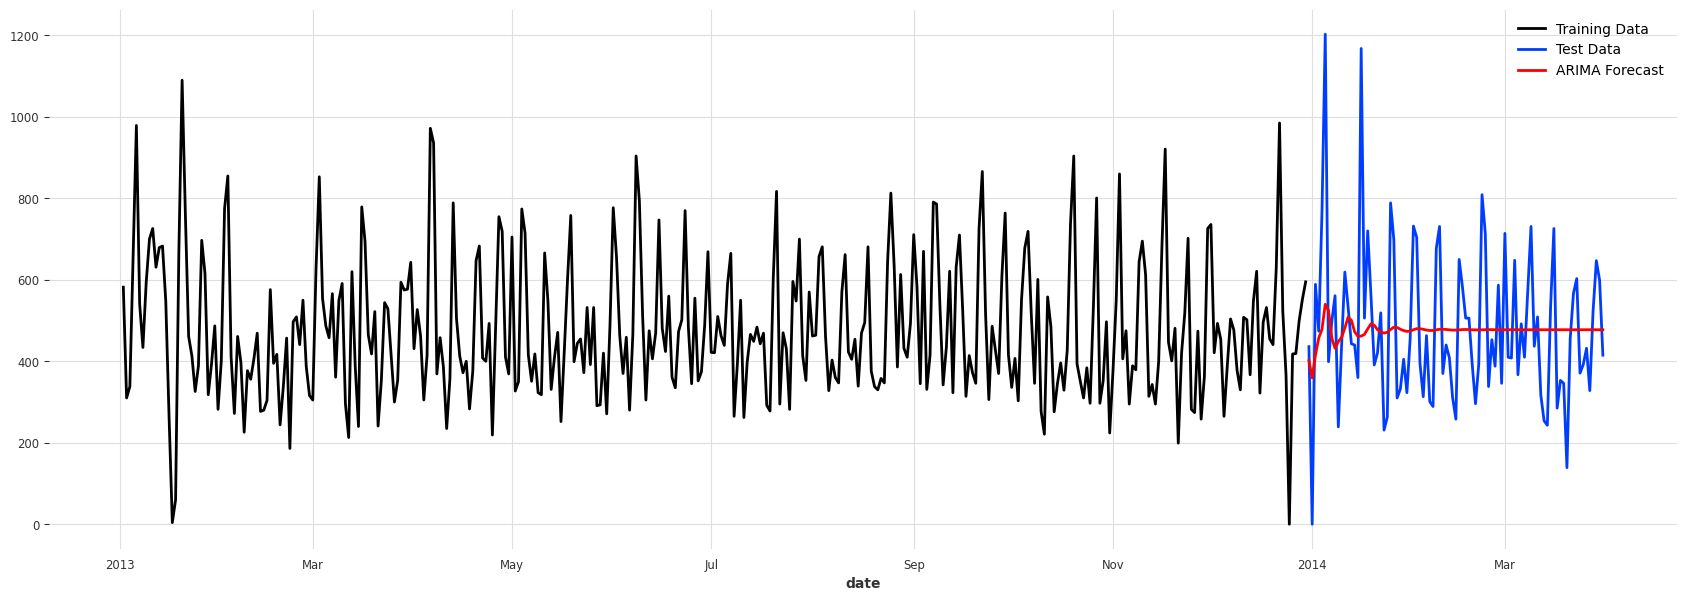

In [ ]:
# Import ARIMA from darts
from darts.models import ARIMA

# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(p=6, d=0, q=1)  # ARIMA(p, d, q)

# Fit the ARIMA model on the training data
arima_model.fit(train)

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model.predict(len(test))

# Plot ARIMA forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train.plot(label='Training Data')
test.plot(label='Test Data')
arima_forecast.plot(label='ARIMA Forecast', color='red')

# Warum ARIMA hier Probleme hat
- Wöchentliche Saisonalität ignoriert
Blaue Spitzen treten fast alle 7 Tage wieder auf, die rote Linie ist jedoch nicht erkennbar – unser Modell hat keine saisonalen MA/AR-Begriffe.
- Kurzzeitgedächtnis-Mittelwertumkehr
Die gewählte ARIMA-Reihenfolge (nicht saisonal) legt das größte Gewicht auf sehr aktuelle Beobachtungen und sinkt dann auf den Mittelwert ab.
Gut für rauscharme Daten, schlecht für plötzliche Ausbrüche.
- Keine exogenen Signale
Werbeaktionen, Feiertage oder Wochentags-Dummys würden dabei helfen, die großen Sprünge zu kennzeichnen.

# ARIMA-Modellauswertung

## Schritt 2: Bewerten Sie die Kandidatenmodelle mit Metriken


- AIC / BIC
    - Belohnt gute Anpassung, bestraft zusätzliche Parameter. Der niedrigste Wert gewinnt. Wird zum Vergleich zwischen Modellen verwendet und ist eine relative Metrik.
- MAE / RMSE auf dem Testset
    - Gibt an, wie gut das Modell auf unbekannte Daten verallgemeinert werden kann. Der niedrigste Wert gewinnt.

In [ ]:
from sklearn.metrics import mean_absolute_error
# Evaluate one model
aic = arima_model.model.aic
mae = mean_absolute_error(test.values().flatten() , arima_forecast.values().flatten())
print("AIC: ",aic)
print("MAE: ",mae)

AIC:  4630.971745881057
MAE:  142.83226591816378


#💡Probieren Sie es selbst aus!  
Erstellen Sie eine Funktion, die alle Kombinationen von q=0,1 und p=1..6 ausprobiert und für jede Kombination ein ARIMA-Modell trainiert. Welches Modell sieht für Sie am besten aus und warum?

In [ ]:
def simple_arima_search(train_ts, test_ts, d=0):
    best_aic  = float('inf')
    best_mae  = float('inf')
    best_order = None
    best_model = None
    results = []

    for p in range(1, 7):          # p = 1 … 6
        for q in (0, 1):           # q = 0 or 1
            model = ARIMA(p=p, d=d, q=q)
            model.fit(train_ts)

            pred = model.predict(len(test_ts))
            mae  = mean_absolute_error(test_ts.values().flatten(),
                                       pred.values().flatten())
            aic  = model.model.aic     # statsmodels AIC

            print(f"ARIMA({p},{d},{q})  AIC = {aic:.1f}  MAE = {mae:.2f}")
            results.append((p, q, aic, mae))

            # keep the model with the lowest AIC (tie-break with MAE)
            if (aic < best_aic) or (aic == best_aic and mae < best_mae):
                best_aic, best_mae = aic, mae
                best_order, best_model = (p, d, q), model

    print(f"Best model: ARIMA{best_order}  AIC = {best_aic:.1f}  MAE = {best_mae:.2f}")
    return best_model, results

best_arima, grid_results = simple_arima_search(train, test)
best_arima

ARIMA(1,0,0)  AIC = 4733.4  MAE = 144.17
ARIMA(1,0,1)  AIC = 4698.3  MAE = 144.24
ARIMA(2,0,0)  AIC = 4686.7  MAE = 143.69
ARIMA(2,0,1)  AIC = 4687.8  MAE = 143.78
ARIMA(3,0,0)  AIC = 4688.7  MAE = 143.70
ARIMA(3,0,1)  AIC = 4687.8  MAE = 143.75
ARIMA(4,0,0)  AIC = 4667.3  MAE = 144.06
ARIMA(4,0,1)  AIC = 4665.1  MAE = 144.46
ARIMA(5,0,0)  AIC = 4656.3  MAE = 144.70
ARIMA(5,0,1)  AIC = 4655.4  MAE = 144.38
ARIMA(6,0,0)  AIC = 4644.8  MAE = 142.77
ARIMA(6,0,1)  AIC = 4631.0  MAE = 142.83
Best model: ARIMA(6, 0, 1)  AIC = 4631.0  MAE = 142.83


ARIMA(p=6, d=0, q=1, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

- Was Sie beachten sollten
  - Führen Sie Ihre Auswertung immer auf Grundlage zurückgehaltener Daten durch – die Genauigkeit des Trainingsdatensatzes allein kann irreführend sein.
  - Verwenden Sie sowohl AIC/BIC als auch Validierungsfehler ; sie erzählen ergänzende Geschichten.
  - Kleinstes, einfachstes Modell, das bei den Daten gewinnt = beste erste Wahl.
  - Zeichnen Sie als Nächstes die verbleibende ACF auf . Die Residuen sollten wie weißes Rauschen aussehen. Andernfalls verfeinern Sie das Modell.

## 💡Übung:
Führen Sie für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), dieselben Schritte aus und wählen Sie das beste Modell aus. Interpretieren Sie Ihre Ergebnisse.

---

## Saisonale Bestellungen für SARIMA auswählen: Schritt 1
Schritt 1. Bestätigen Sie den Saisonzeitraum 7 24

Schritt 2. Sichtprüfung


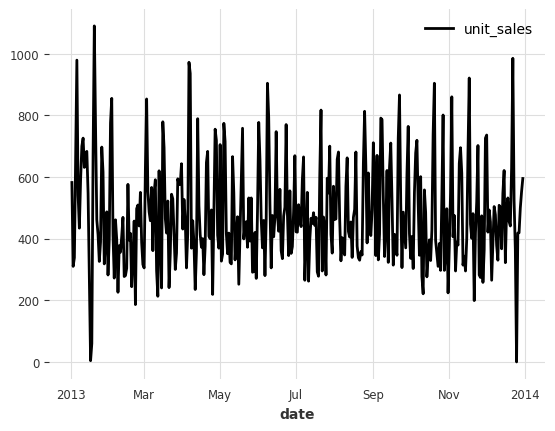

In [ ]:
train.plot();                # visual peaks

## 💡Erst denken!
Was sehen Sie in der Handlung?
Unsere Analyse
Bei einem schnellen visuellen Scan können Sie „Grate“ (überdurchschnittlich hohe Punktansammlungen) und „Täler“ erkennen, die sich in einem ziemlich gleichmäßigen Rhythmus wiederholen.
Markiert man eine beliebige Spitze und zählt sie bis zur nächsten ähnlich hohen Spitze weiter, gelangt man nach etwa sieben Tagen jedes Mal an die gleiche Stelle. Damit ist die 7-Tage-Periode die plausibelste saisonale Periode für diese tägliche Serie – ein klassischer Wochenzyklus.

Schritt 3. Überprüfen Sie den ACF auf Spitzen

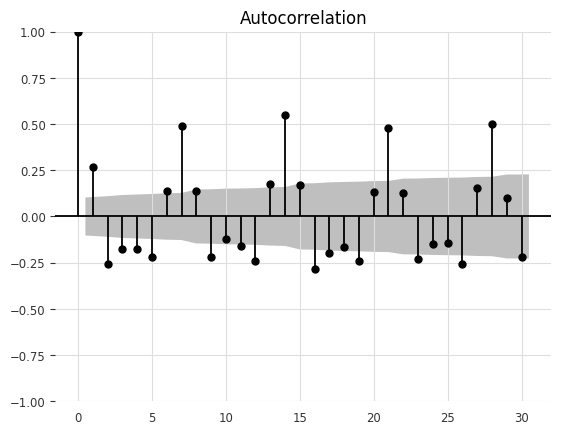

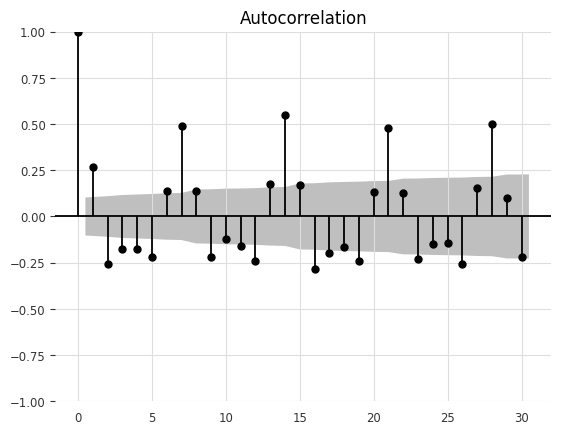

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train.values().flatten(), lags=30)          # look for bars at s, 2s, 3s …

## 💡Erst denken!
Was sehen Sie in der Handlung?
Unsere Analyse
Starke positive Lag 1-Spitze
Die Umsätze von gestern sind ein sehr guter Indikator für die heutige Entwicklung – ein klassisches Momentum mit kurzer Erinnerungsdauer.
Regelmäßige positive Spitzen bei den Verzögerungen 7, 14, 21, 28
Ein klarer Wochenzyklus (Periode = 7 Tage). Jeden siebten Tag steigt die Autokorrelation wieder auf etwa 0,5, was den „Gleicher-Tag-letzte-Woche“-Effekt bestätigt.
Abwechselnde negative Balken zwischen diesen wöchentlichen Spitzen
Werte, die etwa eine halbe Woche auseinander liegen, bewegen sich in entgegengesetzte Richtungen, was typisch für eine Reihe mit stetiger Saisonalität, aber ohne langfristigen Trend ist.

## Bestätigen Sie die Saisonzeiträume


## Fazit für Schritt 1
Saisonlänge ( m) = 7. Wöchentliches Muster ist dominant.

## 💡Übung
Für das gleiche Geschäft, aber einen anderen Artikel ( 103665 ), führen Sie die gleichen Schritte aus und entscheiden Sie sich für m .

---

## Stationarisieren mit gewöhnlicher und saisonaler Differenzierung
Saisonale Bestellungen für SARIMA auswählen: Schritt 2-3

## Lesen Sie saisonale ACF/PACF-Spitzen, um P und Q zu erraten

Schritt 2 und 3. Saisonale Differenzierung (D) und Schätzung (P, Q) aus saisonalen Verzögerungen

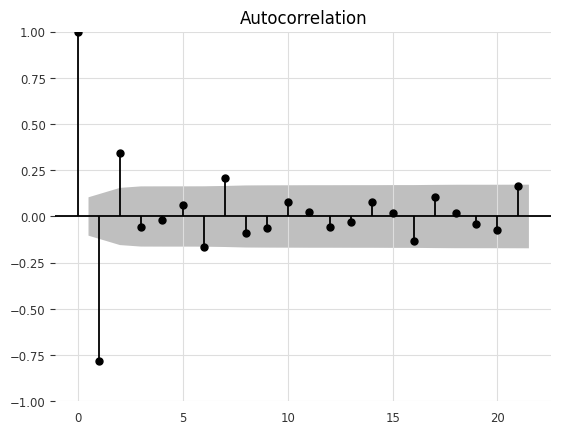

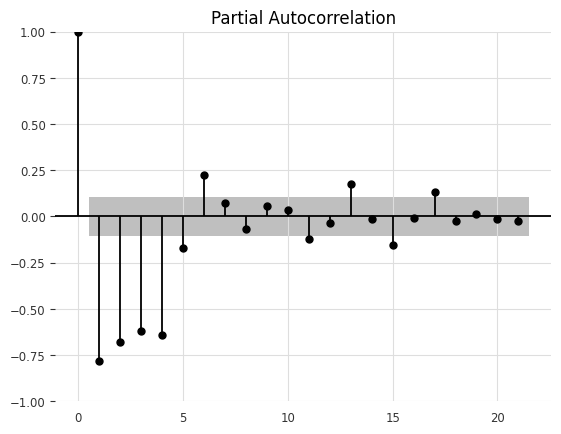

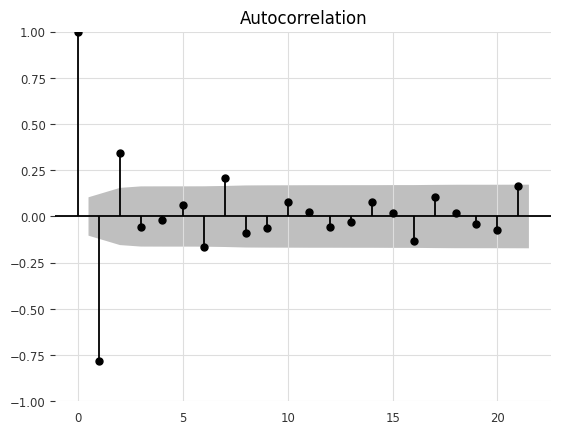

In [ ]:
# Lets do 7-day Seasonal Differencing
from statsmodels.graphics.tsaplots import plot_pacf

arr = train.values().flatten()   # flatten to 1-d if it's uni-variate
diff_season = np.diff(arr,7)

s=7
plot_pacf(diff_season, lags=3*s)   # look at lags s, 2s…
plot_acf (diff_season, lags=3*s)

## Rastersuche in einer kleinen Menge von (p, q) × (P, Q)

Zur Wahl von P und Q: Nach der saisonalen Differenzierung ( D = 1, m = 7) würde man erwarten, dass sich die verbleibende Saisonalität als signifikante Spitzen bei den Verzögerungen 7, 14, 21… in der ACF/PACF zeigt. Wir haben irgendwie immer noch signifikante kleine Spitzen, so dass der wöchentliche Zyklus irgendwie entfernt wurde. Daher werden wir etablieren P = 1undQ = 1.

## 💡Übung
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte.

---

## Passen Sie die Modelle an das Raster aus Schritt 4 an
Schritt 4. Mit nicht saisonalen Bestellungen kombinieren

In [ ]:
# six non-seasonal (p,d,q) combos …
pdq      = [(4,0,0), (4,0,1), (5,0,0), (5,0,1), (6,0,0), (6,0,1)]

# … tested against two seasonal (P,D,Q,m) settings
seasonal = [(0,1,0,7), (0,1,1,7), (0,1,0,7), (0,1,1,7)]

In [ ]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,33412,2013-01-02,44,1047679,582.0,NaN
1,73815,2013-01-03,44,1047679,310.0,NaN
2,113679,2013-01-04,44,1047679,338.0,NaN
3,155808,2013-01-05,44,1047679,654.0,NaN
4,197767,2013-01-06,44,1047679,979.0,NaN


In [ ]:
import itertools
import warnings
import statsmodels.api as sm
import pandas as pd

# Definieren der festen und zu testenden Parameter
d_fixed = 0 # Fester Wert für die nicht-saisonale Differenzierung (aus pdq-Liste)
D_fixed = 1 # Fester Wert für die saisonale Differenzierung (aus seasonal-Liste)
m_fixed = 7 # Saisonale Periodizität

# Nicht-saisonale (p, d, q) Kombinationen
pdq_combos = [
    (4, d_fixed, 0), (4, d_fixed, 1),
    (5, d_fixed, 0), (5, d_fixed, 1),
    (6, d_fixed, 0), (6, d_fixed, 1)
]

# Saisonale (P, D, Q, m) Kombinationen
# Nur P und Q variieren. D und m sind fest.
seasonal_combos = [
    (0, D_fixed, 0, m_fixed),  # P=0, Q=0
    (0, D_fixed, 1, m_fixed)   # P=0, Q=1
]

# Initialisieren des DataFrames zur Speicherung der Ergebnisse (df_ML)
df_ML = pd.DataFrame(columns=['param', 'param_seasonal', 'AIC', 'BIC'])

warnings.filterwarnings("ignore") # Unterdrückt Warnungen

print("Starte Rastersuche über 12 Modellkombinationen...")

for param in pdq_combos:
    for param_seasonal in seasonal_combos:
        param_seasonal_tuple = param_seasonal

        try:
            # WICHTIG: ERSETZEN SIE '<Ihre Zielspalte>' durch Ihren tatsächlichen Spaltennamen
            y = df_train['unit_sales']

            model = sm.tsa.statespace.SARIMAX(
                y,
                order=param,
                seasonal_order=param_seasonal_tuple,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            # Ergebnisse speichern
            new_row = pd.DataFrame({
                'param': [param],
                'param_seasonal': [param_seasonal_tuple],
                'AIC': [results.aic],
                'BIC': [results.bic]
            })
            df_ML = pd.concat([df_ML, new_row], ignore_index=True)

            print(f"SARIMA{param}x{param_seasonal_tuple} - AIC: {results.aic:.4f}")

        except Exception as e:
            print(f"Fehler bei SARIMA{param}x{param_seasonal_tuple}: {e}")
            continue

print("\nRastersuche abgeschlossen. Ergebnisse in df_ML gespeichert.")

# Sortieren der Ergebnisse nach AIC
df_ML_sorted = df_ML.sort_values(by='AIC').reset_index(drop=True)

print("\n🏆 **Top-SARIMA-Modelle nach AIC:**")
print(df_ML_sorted.head())

Starte Rastersuche über 12 Modellkombinationen...
SARIMA(4, 0, 0)x(0, 1, 0, 7) - AIC: 5789.0822
SARIMA(4, 0, 0)x(0, 1, 1, 7) - AIC: 5499.8756
SARIMA(4, 0, 1)x(0, 1, 0, 7) - AIC: 5789.1705
SARIMA(4, 0, 1)x(0, 1, 1, 7) - AIC: 5478.5437
SARIMA(5, 0, 0)x(0, 1, 0, 7) - AIC: 5773.4953
SARIMA(5, 0, 0)x(0, 1, 1, 7) - AIC: 5500.3861
SARIMA(5, 0, 1)x(0, 1, 0, 7) - AIC: 5774.7848
SARIMA(5, 0, 1)x(0, 1, 1, 7) - AIC: 5480.3303
SARIMA(6, 0, 0)x(0, 1, 0, 7) - AIC: 5751.5247
SARIMA(6, 0, 0)x(0, 1, 1, 7) - AIC: 5502.1501
SARIMA(6, 0, 1)x(0, 1, 0, 7) - AIC: 5700.3058
SARIMA(6, 0, 1)x(0, 1, 1, 7) - AIC: 5481.1792

Rastersuche abgeschlossen. Ergebnisse in df_ML gespeichert.

🏆 **Top-SARIMA-Modelle nach AIC:**
       param param_seasonal          AIC          BIC
0  (4, 0, 1)   (0, 1, 1, 7)  5478.543728  5507.087223
1  (5, 0, 1)   (0, 1, 1, 7)  5480.330328  5512.951466
2  (6, 0, 1)   (0, 1, 1, 7)  5481.179187  5517.877967
3  (4, 0, 0)   (0, 1, 1, 7)  5499.875646  5524.355246
4  (5, 0, 0)   (0, 1, 1, 7)  55

## 💡Übung
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte.

---

## Wählen Sie das beste Modell anhand von AIC/BIC und Hold-Out-Fehler

## Anpassen von SARIMA: Schritt 5

<Axes: xlabel='date'>

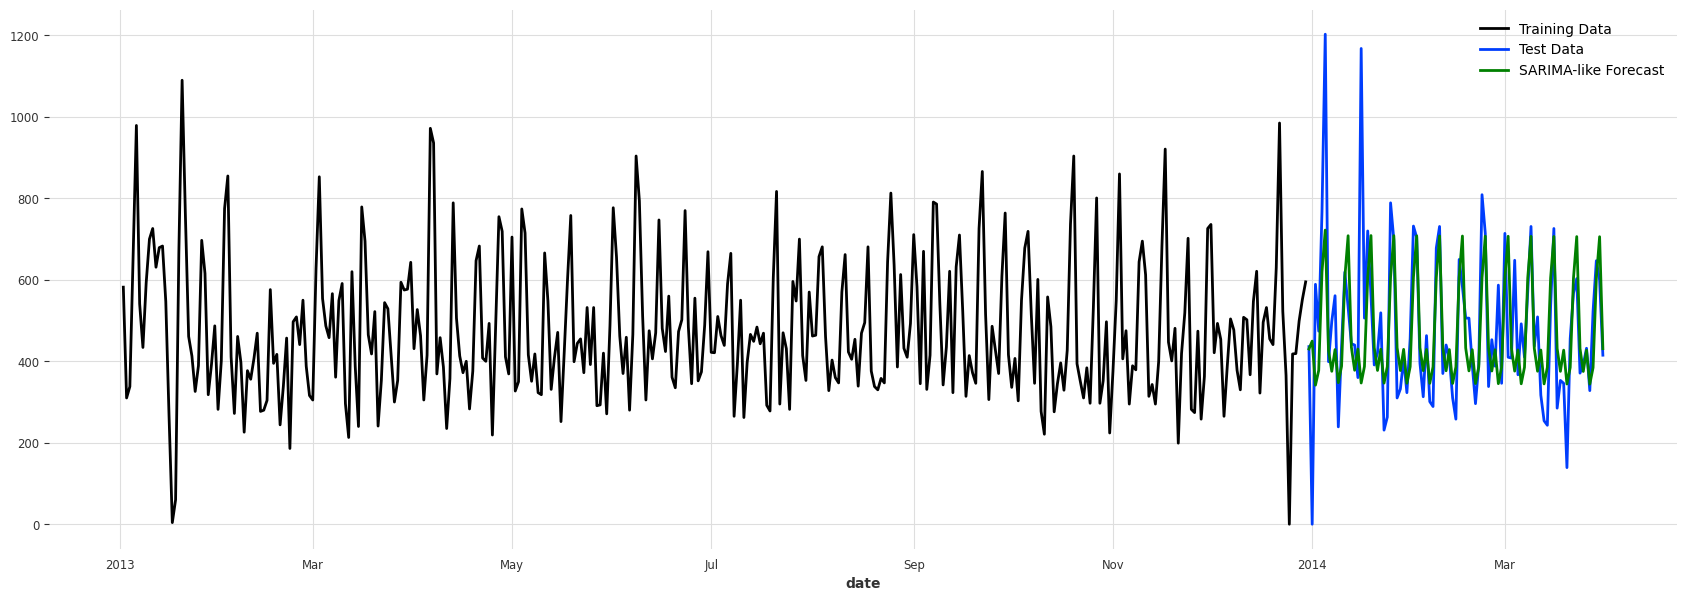

In [ ]:
from darts.models import ARIMA

# Initialize ARIMA model with both (p, d, q) and (P, D, Q, m) parameters
# We will start by trying the guess of our analysis, we will then go to the grid as part of the exercise.
sarima_like_model = ARIMA(p=5, d=1, q=1, seasonal_order=(1, 1, 1, 7))

# Fit the ARIMA model with seasonality on the training data
sarima_like_model.fit(train)

# Forecast the next values (the same length as the test set)
sarima_forecast = sarima_like_model.predict(len(test))

# Plot SARIMA-like forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train.plot(label='Training Data')
test.plot(label='Test Data')
sarima_forecast.plot(label='SARIMA-like Forecast', color='green')

## 💡Übung
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte.

---

## Anpassen von SARIMA: Schritt 6
Schritt 6. Auswerten und diagnostizieren

- Berechnen Sie AIC/BIC für jedes angepasste Modell – niedriger ist besser .
- Bewerten Sie den Out-of-Sample-MAE oder RMSE anhand eines Holdout-Sets – niedriger ist besser .
- Wenn dasselbe Modell bei beiden Kriterien am besten abschneidet, haben Sie ein gut abgestimmtes SARIMA gefunden, das für die Prognose bereit ist.

In [ ]:
# Evaluate
aic = sarima_like_model.model.aic
mae   = mean_absolute_error(test.values().flatten() , sarima_forecast.values().flatten() )
print("AIC: ",aic)
print("MAE: ",mae)

AIC:  4422.4702737798325
MAE:  97.85903009074654


- Interpretieren Sie das Diagramm aus Schritt 5 mit den Bewertungsmetriken aus diesem Schritt. Anschließend können Sie es mit unserer Interpretation vergleichen, indem Sie diesen Schalter öffnen.
  - Sowohl das Diagramm als auch die Fehlerzahlen übertreffen das einfache ARIMA-Modell um Längen – das SARIMA-Modell verfolgt die wöchentlichen Spitzen, anstatt sie abzuflachen. Kurz gesagt: Durch die Hinzufügung des saisonalen MA-Terms konnte das Modell den 7-Tage-Rhythmus erfassen, den ARIMA immer wieder vermisste.

In [ ]:
from darts.models import ARIMA
from sklearn.metrics import mean_absolute_error

pdq      = [(4,0,0), (4,0,1), (5,0,0), (5,0,1), (6,0,0), (6,0,1)]
seasonal = [(0,1,0,7), (0,1,1,7)]

best_aic = float('inf')
best_cfg = None

for order in pdq:
    for s_order in seasonal:
        model = ARIMA(*order, seasonal_order=s_order)
        model.fit(train)

        pred = model.predict(len(test))
        mae  = mean_absolute_error(test.values().flatten(),
                                   pred.values().flatten())
        aic  = model.model.aic          # one extra line

        print(f"SARIMA{order}×{s_order}   AIC = {aic:.1f}   MAE = {mae:.2f}")

        if aic < best_aic:              # pick by lowest AIC
            best_aic, best_cfg = aic, (order, s_order)

print(f"\n🏆 Best model: SARIMA{best_cfg[0]}×{best_cfg[1]}   AIC = {best_aic:.1f}")


SARIMA(4, 0, 0)×(0, 1, 0, 7)   AIC = 4635.0   MAE = 179.45
SARIMA(4, 0, 0)×(0, 1, 1, 7)   AIC = 4418.8   MAE = 97.72
SARIMA(4, 0, 1)×(0, 1, 0, 7)   AIC = 4636.2   MAE = 180.16
SARIMA(4, 0, 1)×(0, 1, 1, 7)   AIC = 4418.6   MAE = 97.65
SARIMA(5, 0, 0)×(0, 1, 0, 7)   AIC = 4635.6   MAE = 180.09
SARIMA(5, 0, 0)×(0, 1, 1, 7)   AIC = 4420.0   MAE = 97.78
SARIMA(5, 0, 1)×(0, 1, 0, 7)   AIC = 4636.2   MAE = 179.66
SARIMA(5, 0, 1)×(0, 1, 1, 7)   AIC = 4420.8   MAE = 98.10
SARIMA(6, 0, 0)×(0, 1, 0, 7)   AIC = 4618.1   MAE = 166.84
SARIMA(6, 0, 0)×(0, 1, 1, 7)   AIC = 4420.2   MAE = 97.92
SARIMA(6, 0, 1)×(0, 1, 0, 7)   AIC = 4579.7   MAE = 162.79
SARIMA(6, 0, 1)×(0, 1, 1, 7)   AIC = 4422.2   MAE = 97.72

🏆 Best model: SARIMA(4, 0, 1)×(0, 1, 1, 7)   AIC = 4418.6


☝🏼
Die Auswahl eines Wertesatzes für die Modellparameter ist entscheidend. Wir empfehlen dringend, dieser Anleitung zur Parameterauswahl zu folgen.

## Wichtige Erkenntnisse
SARIMA = ARIMA + saisonale Ebene ; Sie benötigen es nur, wenn ACF/PACF wiederkehrende saisonale Spitzen aufweisen.
Die Saisonlänge ist der erste große Hinweis → fast immer aus dem Geschäftskontext bekannt (wöchentlich, monatlich, vierteljährlich).
Beginnen Sie einfach: (p,d,q) aus ARIMA + (P,D,Q) = (1,1,1) und iterieren Sie.
Lassen Sie sich bei der Verfeinerung von AIC/BIC und Validierungsfehlern leiten , genau wie bei ARIMA.

## 💡 Übung
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte.

---

# Mängel der ARIMA- und SARIMA-Methoden

Obwohl ARIMA und SARIMA leistungsstarke Techniken zur Zeitreihenprognose sind, weisen sie einige Einschränkungen auf:
  - Stationaritätsanforderung : Sowohl ARIMA als auch SARIMA gehen davon aus, dass die Daten stationär sind, d. h., ihre statistischen Eigenschaften (wie Mittelwert und Varianz) ändern sich im Laufe der Zeit nicht. Dies erfordert häufig eine Transformation oder Differenzierung der Daten, was bei komplexen, nichtlinearen Reihen eine Herausforderung darstellen kann.
  - Eingeschränkter Umgang mit Nichtlinearität : ARIMA und SARIMA sind lineare Modelle, was bedeutet, dass sie möglicherweise Schwierigkeiten haben, komplexe nichtlineare Beziehungen in den Daten zu erfassen.
  - Saisonalitätsprobleme : SARIMA kann Saisonalität verarbeiten, allerdings nur, wenn diese konsistent und klar definiert ist. Ändert sich die Saisonalität im Laufe der Zeit oder gibt es mehrere saisonale Muster, kann die Leistung von SARIMA beeinträchtigt sein.
  - Hoher Rechenaufwand bei großen Datenmengen : Das Anpassen von ARIMA- oder SARIMA-Modellen kann bei großen Datensätzen oder langen Zeitreihen rechenintensiv sein, da die Modelle über viele Verzögerungen iterieren müssen.
  - Keine Unterstützung exogener Variablen in Basic ARIMA/SARIMA : ARIMA und SARIMA können die Daten zwar auf Grundlage ihrer eigenen vergangenen Werte modellieren, sie integrieren jedoch externe Einflüsse (exogene Variablen) nicht ohne Weiteres, es sei denn, Sie verwenden Erweiterungen wie ARIMAX .
Es gibt viele andere klassische Methoden, die diese Nachteile nicht aufweisen, z. B. die exponentielle Glättung oder ARIMAX (AutoRegressive Moving Average with Exogenous Variables). Wir werden diese Methoden in unseren Lektionen nicht behandeln. Wenn Sie jedoch mehr über klassische Zeitreihenmethoden erfahren möchten, sehen Sie sich bitte die für diese Woche vorgeschlagenen Zusatzmaterialien an.

# 💡
Das Notebook mit dem in dieser Lektion verwendeten Codebeispiel finden Sie hier .
Sie haben Lesezugriff auf die Notizbücher. Um sie auszuführen und zu ändern, kopieren Sie sie in Ihren Google Drive-Speicher.

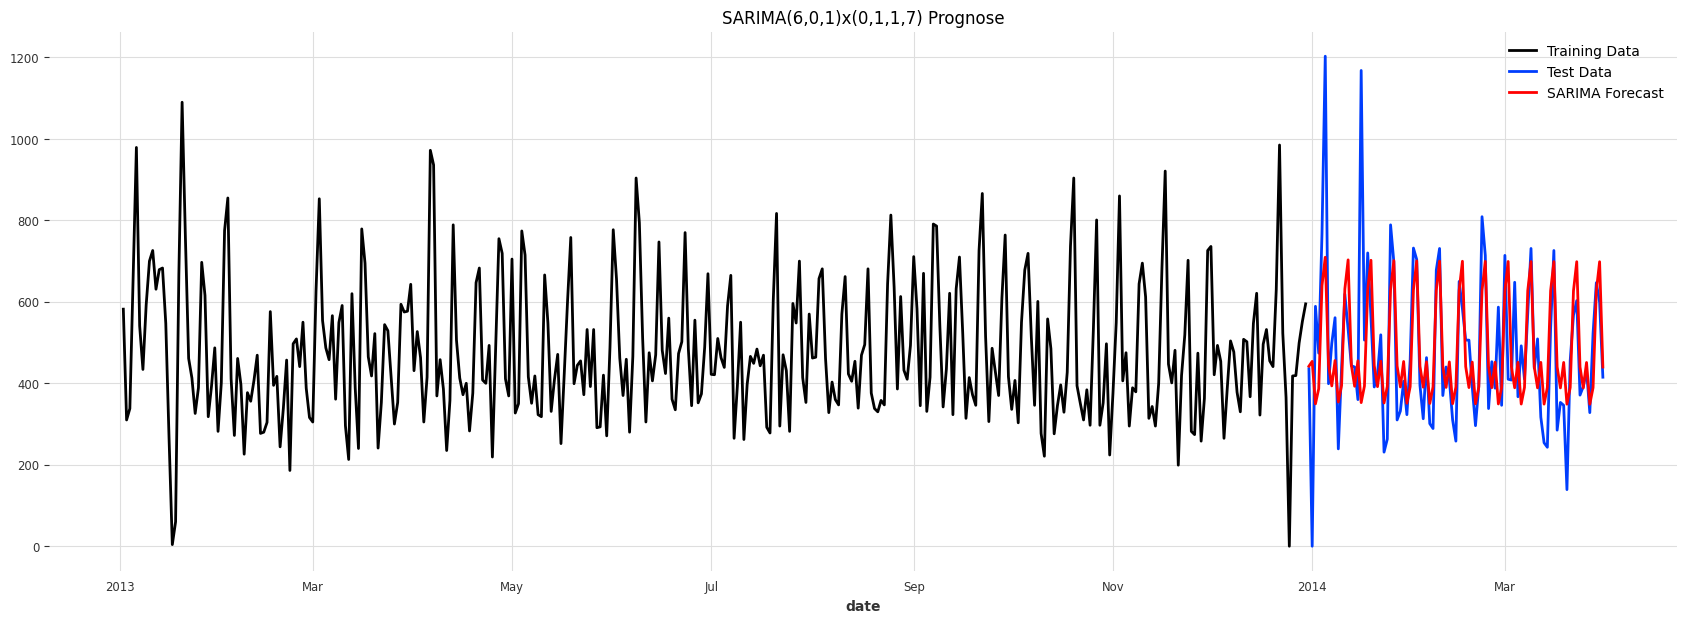

SARIMA(6,0,1)x(0,1,1,7)
AIC: 4422.2
MAE: 97.7


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from darts.models import ARIMA
from sklearn.metrics import mean_absolute_error

p = 6
d = 0
q_test = 1 # in diesen fall sind 0 und 1 q zu testen
s = 7

# Feste saisonale Parameter basierend auf der Rastersuche, z.B. (0, 1, 1, 7)
P_fixed = 0
D_fixed = 1
Q_fixed = 1
seasonal_order = (P_fixed, D_fixed, Q_fixed, s)

# KORREKTUR: ARIMA-Klasse direkt verwenden und seasonal_order übergeben
arima_model = ARIMA(
    p=p,
    d=d,
    q=q_test,
    seasonal_order=seasonal_order # Übergabe der saisonalen Parameter
)

# Annahme: 'train' ist eine darts.TimeSeries
arima_model.fit(train)

# Prognose und Evaluierung

arima_forecast = arima_model.predict(len(test))

# Plot ARIMA forecast vs actual data
plt.figure(figsize=(21, 7))
train.plot(label='Training Data')
test.plot(label='Test Data')
arima_forecast.plot(label='SARIMA Forecast', color='red')
plt.title(f"SARIMA({p},{d},{q_test})x({P_fixed},{D_fixed},{Q_fixed},{s}) Prognose")
plt.show()

# Evaluate one model
# AIC ist über das interne statsmodels-Modell zugänglich
aic = arima_model.model.aic
mae = mean_absolute_error(test.values().flatten(), arima_forecast.values().flatten())

print(f"SARIMA({p},{d},{q_test})x({P_fixed},{D_fixed},{Q_fixed},{s})")
print(f"AIC: {round(aic, 1)}")
print(f"MAE: {round(mae, 1)}")

# Abschluss ARIMA / SARIMA ab hier werd daten satz neu geladen

---


# Maschinelles Lernen für Zeitreihen
1. Warum über die „klassische“ Prognose hinausgehen?
- Erfassen Sie nichtlineare Muster , die lineares ARIMA nicht erkennen kann.
- Absorbieren Sie viele Kovariate (Wetter, Werbeaktionen, Webverkehr) ohne manuelles Feature-Engineering.
- Skalieren Sie auf Hunderte oder Tausende von Serien, indem Sie Parameter teilen (Boosted Trees, Deep Nets).
- Bewältigen Sie langfristige Prognosen besser, indem Sie die globale Struktur statt einer schrittweisen Rekursion erlernen.
2. Wie ML Zeitreihen anders behandelt
Eingabeform
Stationarität
Modellfamilie
Prognosestrategie
3. Gängige ML-Modelle für Zeitreihen
Tree-based ensembles
Recurrent Neural Networks RNN, LSTM, GRU
Temporal Convolutional Networks (TCN) & 1-D CNNs
Transformers / Attention models
Hybrid or “Statistical + ML”



## Erstellen von Lag- und Rolling-Window-Funktionen für Baummodelle
Schritt-für-Schritt-Code-Komplettlösung

1. Daten laden und vorbereiten

2. Feature Engineering für maschinelles Lernen

2.1. Erstellen von Lag-Funktionen


Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=d83e3a65-ec39-4490-9a65-cc9cda1645ff
To: /content/train.csv
100%|██████████| 5.00G/5.00G [00:50<00:00, 98.1MB/s]


<Axes: xlabel='date'>

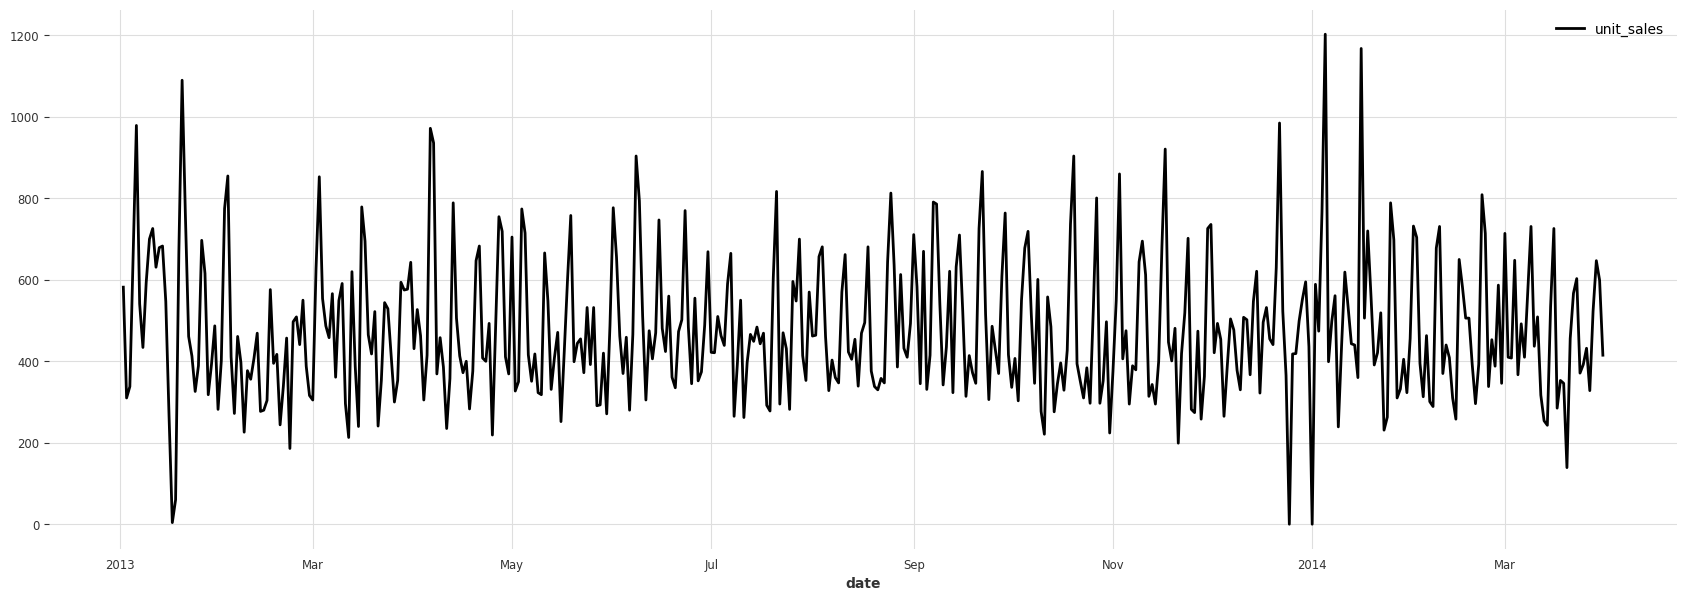

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from darts import TimeSeries
import requests
import io
import gdown

# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

def read_metadata_files(file_ids):
  # Read all files but train.csv
  # Load each CSV using the helper functions
  df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
  df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
  df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
  df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
  df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
  return df_holiday_events, df_items, df_oil, df_stores, df_transactions

# Dictionary of file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

df_holiday_events, df_items, df_oil, df_stores, df_transactions = read_metadata_files(file_ids)

# Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

# Load stores and get Pichincha store IDs
stores_url = make_drive_url(file_ids["stores"])
df_stores = pd.read_csv(io.StringIO(requests.get(stores_url).text))
store_ids = df_stores[df_stores['state'] == 'Pichincha']['store_nbr'].unique()

# NEW!
# Let's filter the data for one store and one item to keep it simple
store_ids = [44]
item_ids = [1047679]
#Select data before April'14
max_date = '2014-04-01'

# Read train.csv in chunks and filter for Pichincha region
chunk_size = 10**6
filtered_chunks = []

for chunk in pd.read_csv("train.csv", chunksize=chunk_size):
    # old: chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]
    # NEW!
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    filtered_chunks.append(chunk_filtered)
    del chunk

# Combine and sample
df_filtered = pd.concat(filtered_chunks, ignore_index=True)#.sample(n=2_000_000, random_state=42).reset_index(drop=True)

# Clean up memory
del filtered_chunks

df_filtered['date'] = pd.to_datetime(df_filtered['date'])
# Group by date and aggregate sales for each day
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales (since some dates may have no sales)
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_filtered, value_cols='unit_sales')

# Visualize the filtered sales data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
series.plot()

In [ ]:
# Create lag features (e.g., sales from the previous day, previous week)
df_filtered['lag_1'] = df_filtered['unit_sales'].shift(1)
df_filtered['lag_7'] = df_filtered['unit_sales'].shift(7)
df_filtered['lag_30'] = df_filtered['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filtered.dropna(inplace=True)

2.2. Erstellen von fortlaufenden Statistiken


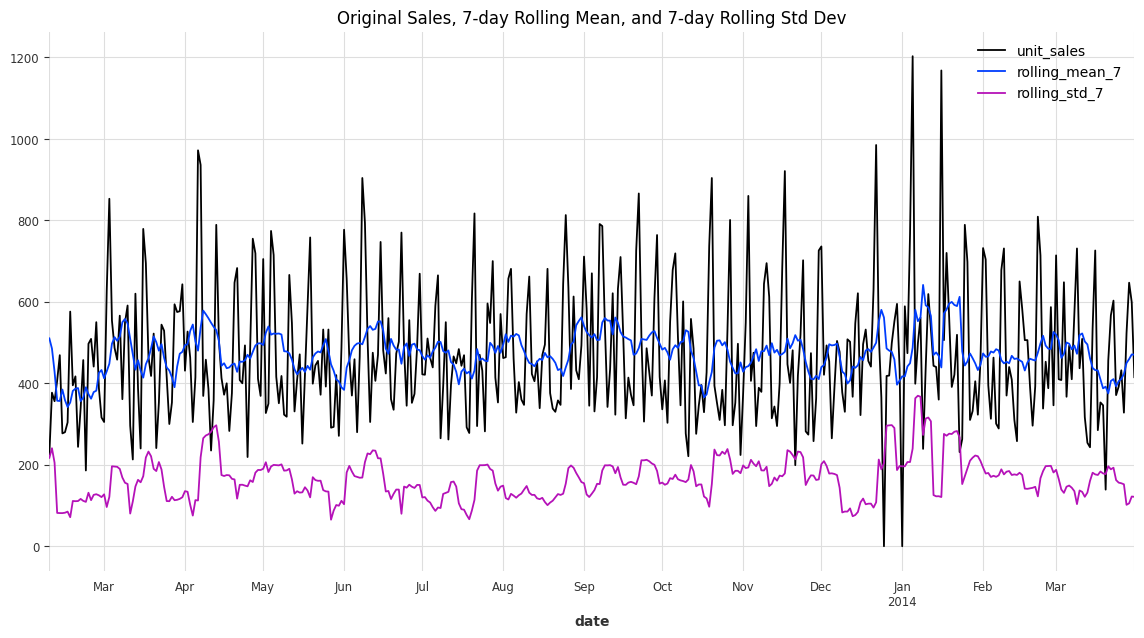

In [ ]:
# Create rolling mean and rolling standard deviation features.
# We need to shift by one before rolling so only past data are used.
df_filtered['rolling_mean_7'] = df_filtered['unit_sales'].shift(1).rolling(window=7).mean()
df_filtered['rolling_std_7'] = df_filtered['unit_sales'].shift(1).rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered.dropna(inplace=True)

# Visualize the new features alongside the original sales
df_filtered[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

2.3. Hinzufügen datumsbasierter Funktionen


In [ ]:
# Add date-based features
df_filtered['day_of_week'] = df_filtered.index.dayofweek
df_filtered['month'] = df_filtered.index.month
df_filtered['is_weekend'] = df_filtered['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

## Wie das Modell diese Funktionen nutzt
- Saisonale Spitzen: Während Wochenenden normalerweise Käufe auslösen, kann sich ein Baum is_weekend == 1an Samstagen/Sonntagen spalten und die Prognose verbessern.
- Feiertagseffekte: Durch das Hinzufügen einer monthoder sogar einer bestimmten Feiertagsflagge lernt das Modell, dass Dezembertage tendenziell höhere gleitende Mittelwerte aufweisen.
- Lokale Glättung: Der gleitende Mittelwert fungiert als dynamische Basislinie. Wenn er steigt, kann der Baum seine Vorhersage erhöhen, selbst wenn die Verzögerung von gestern Null ist.
- Volatilitätsbewusstsein: Hohe rolling_std_7Werte warnen das Modell, dass große Spitzen möglich sind, sodass es möglicherweise eine etwas höhere Basislinie zur Absicherung vorhersagt.

## Wichtige Erkenntnisse
- Lag-Spalten geben dem Modell eine genaue Erinnerung an vergangene Werte.
- Laufende Spalten liefern Kontext zum aktuellen Niveau und zur Volatilität .
- Kalenderspalten kodieren periodische Effekte ohne manuelles One-Hot für jedes Datum.
- Verschieben Sie immer vor dem Rollen und löschen Sie die anfänglichen NaNs, um das Durchsickern zukünftiger Informationen zu vermeiden.

## 💡Probieren Sie es selbst aus!
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte.

---

# XGBoost

☝🏼XGBoost ist ein hochpräziser, schneller und flexibler Algorithmus für maschinelles Lernen, der für eine Vielzahl von Vorhersageaufgaben eingesetzt wird. Wir verwenden ihn für Zeitreihenprognosen, er kann aber auch für andere Regressionsaufgaben sowie zur Klassifizierung verwendet werden.

## Erstellen eines XGBoost-Modells zur Bedarfsprognose

In [ ]:
df_filtered.head()

,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,day_of_week,month,is_weekend
date,,,,,,,,,
2013-02-08,226.0,397.0,401.0,593.0,510.285714,217.081179,4,2,0
2013-02-09,377.0,226.0,775.0,700.0,485.285714,240.570651,5,2,1
2013-02-10,356.0,377.0,855.0,726.0,428.428571,205.104735,6,2,1
2013-02-11,407.0,356.0,411.0,631.0,357.142857,81.770876,0,2,0
2013-02-12,469.0,407.0,272.0,679.0,356.571429,81.344652,1,2,0


1. Aufteilen von Daten in Trainings- und Testsätze


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Temporären DataFrame für die Bereinigung erstellen
df_Cleaning = df_filtered.copy()

# 2. Datumsspalte in Unix-Zeit (Timestamp) umwandeln
# Annahme: Die Datumsspalte heißt 'date'.

try:
    # Sicherstellen, dass die Spalte im richtigen datetime-Format ist
    df_Cleaning['date'] = pd.to_datetime(df_Cleaning['date'])

    # Umwandlung in Unix-Zeit (Sekunden seit 1970) und Speicherung in einer neuen Spalte
    df_Cleaning['date_timestamp'] = df_Cleaning['date'].apply(lambda x: x.timestamp())

    # Die ursprüngliche 'date'-Spalte (Typ: datetime) entfernen
    df_Cleaning = df_Cleaning.drop('date', axis=1)

except KeyError:
    print("Fehler: Die Spalte 'date' wurde nicht gefunden. Bitte den korrekten Spaltennamen prüfen.")
    # Der Code würde hier die weitere Verarbeitung abbrechen, da die Spalte nicht existiert.

# 3. Zielvariable (y) und Features (X) definieren
# 'unit_sales' wird für y entfernt, die neue 'date_timestamp' Spalte bleibt in X
X = df_Cleaning.drop('unit_sales', axis=1)
y = df_Cleaning['unit_sales']

# 4. Daten aufteilen (Beibehaltung der chronologischen Reihenfolge)
# Dies ist entscheidend, da Sie Zeitreihendaten haben: shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Fehler: Die Spalte 'date' wurde nicht gefunden. Bitte den korrekten Spaltennamen prüfen.


In [ ]:
X_train.head()

,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,day_of_week,month,is_weekend
date,,,,,,,,
2013-02-08,397.0,401.0,593.0,510.285714,217.081179,4,2,0
2013-02-09,226.0,775.0,700.0,485.285714,240.570651,5,2,1
2013-02-10,377.0,855.0,726.0,428.428571,205.104735,6,2,1
2013-02-11,356.0,411.0,631.0,357.142857,81.770876,0,2,0
2013-02-12,407.0,272.0,679.0,356.571429,81.344652,1,2,0


In [ ]:
y_train.head()

,unit_sales
date,
2013-02-08,226.0
2013-02-09,377.0
2013-02-10,356.0
2013-02-11,407.0
2013-02-12,469.0


In [ ]:
X_test.head()

,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,day_of_week,month,is_weekend
date,,,,,,,,
2014-01-07,399.0,436.0,477.0,552.571429,369.469375,1,1,0
2014-01-08,498.0,0.0,378.0,561.428571,366.943618,2,1,0
2014-01-09,561.0,589.0,330.0,641.571429,273.167749,3,1,0
2014-01-10,239.0,474.0,508.0,591.571429,313.454865,4,1,0
2014-01-11,438.0,767.0,502.0,586.428571,315.990431,5,1,1


In [ ]:
y_test.head()

,unit_sales
date,
2014-01-07,498.0
2014-01-08,561.0
2014-01-09,239.0
2014-01-10,438.0
2014-01-11,619.0


2. Implementierung von XGBoost für die Zeitreihenprognose


In [ ]:
import xgboost as xgb

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

3. Darstellung der tatsächlichen und prognostizierten Werte

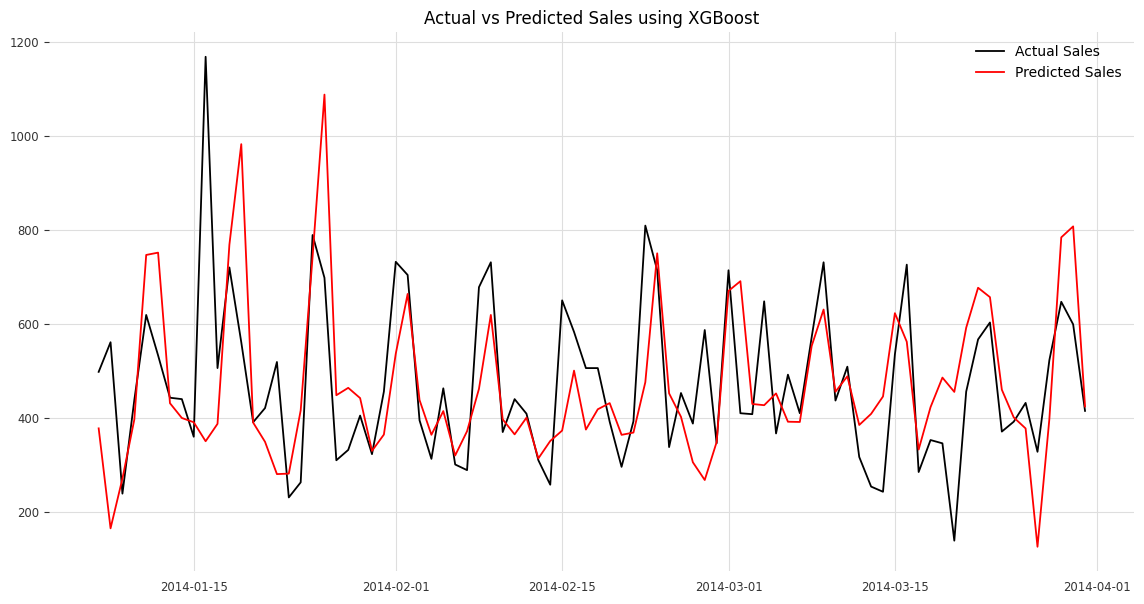

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

## 4. Metriken


In [ ]:
from sklearn.metrics import mean_absolute_error

# y_test and y_pred are Pandas Series aligned by date
mae  = mean_absolute_error(y_test, y_pred)

print(f"MAE   : {mae:.3f} units")

MAE   : 116.167 units


## 💡Probieren Sie es selbst aus!
Ändern Sie die xgboost-Hyperparameter (z. B. n_estimators). Interpretieren Sie Ihren Gewinner.
## 💡Übung:
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte.

## Die wichtigsten Erkenntnisse
☝
Feature Engineering
 Wir haben Lag-Features, rollierende Statistiken und datumsbasierte Features erstellt, um dem XGBoost-Modell dabei zu helfen, zeitliche Abhängigkeiten in den Verkaufsdaten zu erfassen.
Das maschinelle Lernen  
XGBoost wurde anhand dieser Funktionen trainiert, um zukünftige Umsätze vorherzusagen. Es ist ein flexibles und leistungsstarkes Tool, das nichtlineare Beziehungen und mehrere Eingabefunktionen verarbeiten kann.
Leistung
Durch die Auswertung des MAE können wir beurteilen, wie gut das Modell zukünftige Umsätze vorhergesagt hat. Sie können das Modell weiter optimieren, indem Sie Parameter wie n_estimatorsund anpassen max_depth.

# Praxis von LSTM auf dem Bedarfsprognosedatensatz


## Schritt 1: Daten laden und vorbereiten


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from darts import TimeSeries
import requests
import io
import gdown
from google.colab import drive
import sys # Wird für die Überprüfung der Variablendefinition benötigt

# ----------------------------------------------------------------------
# HILFSFUNKTIONEN ZUM LADEN VON METADATEN
# ----------------------------------------------------------------------

# Build the download URL from a file ID
def make_drive_url(file_id):
    """Erzeugt eine direkte Download-URL für eine Google Drive Datei-ID."""
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    """Lädt eine CSV-Datei von einer direkten URL in ein Pandas DataFrame."""
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()  # Löst einen Fehler aus, wenn der Request fehlschlägt
        return pd.read_csv(io.StringIO(response.text))
    except requests.exceptions.RequestException as e:
        print(f"Fehler beim Laden der Datei von URL {url}: {e}")
        return pd.DataFrame() # Gib leeres DF bei Fehler zurück, um Absturz zu vermeiden

def read_metadata_files(file_ids):
    """Lädt alle Metadaten-Dateien außer 'train.csv'."""
    print("Starte Laden der Metadaten-Dateien...")
    try:
        df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
        df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
        df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
        df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
        df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
        print("Metadaten erfolgreich geladen!")
        return df_holiday_events, df_items, df_oil, df_stores, df_transactions
    except Exception as e:
        print(f"Ein Fehler ist beim Laden der Metadaten aufgetreten: {e}")
        # Gib leere DataFrames zurück, um die Ausführung zu ermöglichen
        empty_df = pd.DataFrame()
        return empty_df, empty_df, empty_df, empty_df, empty_df

# ----------------------------------------------------------------------
# HAUPT-AUSFÜHRUNGSBLOCK
# ----------------------------------------------------------------------

# Dictionary of file IDs
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

# Laden der Metadaten-DataFrames
df_holiday_events, df_items, df_oil, df_stores, df_transactions = read_metadata_files(file_ids)

# ----------------------------------------------------------------------
# ROBUSTER BLOCK ZUM LADEN VON df_filtered
# ----------------------------------------------------------------------

# Definieren des Pfades zum großen DataFrame
load_path = "/content/drive/MyDrive/retail_kaggle_data/df_filtered_sprint2.pkl"

# Überprüfen, ob das DataFrame 'df_filtered' bereits im Speicher ist
# Wir verwenden sys.modules[__name__].__dict__ für eine robuste Variablenprüfung
if 'df_filtered' in sys.modules[__name__].__dict__ and isinstance(sys.modules[__name__].__dict__['df_filtered'], pd.DataFrame):
    print("✅ DataFrame 'df_filtered' ist bereits geladen und vom Typ pd.DataFrame. Laden übersprungen.")
else:
    print(f"Versuche, DataFrame von Drive zu laden: {load_path}")
    try:
        # Erneutes Mounten des Google Drive
        # Der Befehl wird hier beibehalten, da er im Original-Code stand, kann aber oft optional sein
        drive.mount('/content/drive')

        # Das Laden des DataFrames mit Fehlerbehandlung
        df_filtered = pd.read_pickle(load_path)

        if df_filtered is not None and not df_filtered.empty:
            print(f"✅ DataFrame 'df_filtered' erfolgreich von '{load_path.split('/')[-1]}' geladen! ({len(df_filtered)} Zeilen)")
        else:
            # Dies sollte bei einer Pickle-Datei selten passieren
            print("⚠️ Datei geladen, aber DataFrame 'df_filtered' ist leer oder None.")

    # Fange den spezifischen FileNotFoundError ab, der zuvor aufgetreten ist
    except FileNotFoundError:
        print(f"❌ FEHLER: Die Datei wurde NICHT gefunden unter: '{load_path}'")
        print("Bitte überprüfen Sie den Pfad und stellen Sie sicher, dass das Drive korrekt gemountet ist.")
    # Fange alle anderen möglichen Fehler ab (z.B. Pickle-Format-Fehler)
    except Exception as e:
        print(f"❌ Ein unerwarteter Fehler beim Laden von df_filtered ist aufgetreten: {e}")

# ----------------------------------------------------------------------
# BEREIT ZUR WEITERARBEIT
# ----------------------------------------------------------------------

print("\n--- Datenlade-Prozess abgeschlossen ---")
print("Bereit zur Weiterarbeit mit allen DataFrames.")


Starte Laden der Metadaten-Dateien...
Metadaten erfolgreich geladen!
✅ DataFrame 'df_filtered' ist bereits geladen und vom Typ pd.DataFrame. Laden übersprungen.

--- Datenlade-Prozess abgeschlossen ---
Bereit zur Weiterarbeit mit allen DataFrames.


## Schritt 2: Vorverarbeitung der Daten für LSTM

📌
Denken Sie daran, den Skalierer nicht auf die gesamte Reihe anzuwenden , einschließlich der Daten, die später zum Testsatz gehören.
Dadurch können Informationen aus der Zukunft die Skalierung der Vergangenheit beeinflussen – genau die Art von Leck, die wir bei der Prognose vermeiden wollen.
Der No-Leak-Workflow ist:
Setzen Sie den Scaler nur auf y_train(oder X_train) auf .
Transformieren Sie sowohl das Training als auch den Test mit diesen Parametern.

Extrahieren Sie die Reihe, die wir vorhersagen möchten

In [ ]:
values = df_filtered['unit_sales'].values.reshape(-1, 1) # This gives us unit sales in a format that our functions like

Erstellen Sie eine angemessene zeitbasierte Trainings-/Testaufteilung

In [ ]:
# Train / test calendar split  (80 / 20): Splits by time—first 80 % for training, last 20 % for testing (no shuffling).
train_cut = int(len(values) * 0.8)
train_raw = values[:train_cut]
test_raw  = values[train_cut:]           # keep future data intact

Skalieren Sie die Daten – aber nur auf dem Trainingssegment

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Fits the Min-Max scaler on the training slice only to avoid leaking future information.
scaler = MinMaxScaler()                  # rescales to the range [0, 1]
train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

Transformieren Sie die 1-D-Reihe in überwachte „Fenster“

Das Netzwerk kann nicht beliebig weit zurückblicken; wir müssen es mit Clips von fester Länge präsentieren.
In jedem Eingabefenster werden die skalierten Verkäufe der letzten 30 Tage gespeichert .
Als Zielwert gilt der Verkaufswert des nächsten Tages .

In [ ]:
# Turn the scaled series into [samples, time_steps, features]

# Creates sliding windows of length 30: each window becomes one training sample, and the next real value becomes the label.
SEQ_LEN = 30                             # past 30 days → predict day 31

def make_sequences(arr, seq_len):
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i : i + seq_len, :])   # seq_len rows × 1 feature
        y.append(arr[i + seq_len, 0])       # target is the very next value
    return np.array(X), np.array(y)

X_train, y_train = make_sequences(train_scaled, SEQ_LEN)
X_test,  y_test  = make_sequences(test_scaled,  SEQ_LEN)

# Returns NumPy arrays shaped exactly as an LSTM expects:
# X_train/test → (samples, time_steps, features) and y_train/test → (samples,).
print("Shapes  →  X_train:", X_train.shape,
      "   y_train:", y_train.shape,
      "   X_test:",  X_test.shape,
      "   y_test:",  y_test.shape)

# X_train is now (samples, 30, 1) — ready for model = Sequential([... LSTM(...), ...])
# ------------------------------------------------------------------
# Note:  use scaler.inverse_transform(y_pred.reshape(-1,1)) later to return to real units

Shapes  →  X_train: (303, 30, 1)    y_train: (303,)    X_test: (54, 30, 1)    y_test: (54,)


- Übergeben Sie diese Arrays an das Modell
Nach der Umformung X_trainhat es genau die 3D-Form, die Keras möchte: (samples, time_steps, features)→ (N, 30, 1).
SequentialVon hier aus können Sie ein Modell mit einer Ebene erstellen LSTM, es an die Trainingsdaten anpassen und die Leistung anhand der Testdaten messen.
- Prognosen auf reale Einheiten zurückführen
Da alles auf skaliert wurde [0, 1], liegen auch die Ausgaben des Modells in diesem Bereich. Nach der Inferenz werden wir scaler.inverse_transform(...)die Prognosen wieder in tatsächliche Stückzahlen umwandeln, damit die Beteiligten die Zahlen lesen können und die Diagramme Sinn ergeben.

# Praxis von LSTM auf Demand-Prognosedatensatz Teil II

## Schritt 3: Erstellen, Trainieren, Vorhersagen treffen und Auswerten des Modells

Definieren wir ein kleines LSTM mit 64 Einheiten, einer Dropout-Schicht und einem linearen Ausgabeneuron.
Trainieren Sie 30 Epochen lang mit MAE-Verlust (passen Sie Epochen/Chargen nach Belieben an).
Generieren Sie Vorhersagen für Ihre zurückgehaltenen Testfenster.
Skaliert sowohl Vorhersagen als auch die Grundwahrheit invers, sodass die Darstellung in realen Verkaufszahlen erfolgt.
Stellt die beiden Reihen grafisch dar, sodass Sie erkennen können, wo das Modell zu weit oder zu weit schießt.



## Bauen Sie die Netzwerkstruktur auf – „das Gehirn“

- Wir erstellen ein SequentialModell, das lediglich aus einem Stapel von Schichten von oben nach unten besteht.
- LSTM(64): 64 Speicherzellen betrachten die letzten 30 Zeitschritte und komprimieren diesen Verlauf in einen verborgenen Vektor.
- Dropout(0.2): Während des Trainings werden bei jedem Schritt 20 % der Neuronen zufällig stummgeschaltet, sodass das Netzwerk die Trainingsdaten nicht einfach auswendig lernen kann.
- Dense(1): Ein einzelnes lineares Neuron wandelt den verborgenen Vektor in die prognostizierten Umsätze von morgen um.

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# 1. Build a simple LSTM model
# ------------------------------------------------------------------
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(1)                       # one value: next-day sales
])

## Sagen Sie Keras, wie es lernen soll

In [ ]:
model.compile(optimizer="adam", loss="mae")

## Trainieren des Netzwerks

Epochen = 30 bedeutet, dass die Trainingsfenster 30 Mal durchlaufen werden.
Batchgröße = 32 weist Keras an, die Gewichte nach jeweils 32 Samples zu aktualisieren – klein genug, um in den Speicher zu passen, groß genug für stabile Gradienten.
validation_split=0.1– die letzten 10 % X_trainwerden in jeder Epoche zurückgehalten, damit wir während des Trainings auf Überanpassung achten können.

In [ ]:
# ------------------------------------------------------------------
# 2. Train
# ------------------------------------------------------------------
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=2 # This is so we can see on the screen one compact line per epoch (Epoch 1/30 loss=… val_loss=…).
)

Epoch 1/30
9/9 - 3s - 366ms/step - loss: 0.1977 - val_loss: 0.1310
Epoch 2/30
9/9 - 0s - 29ms/step - loss: 0.1270 - val_loss: 0.1387
Epoch 3/30
9/9 - 0s - 26ms/step - loss: 0.1188 - val_loss: 0.1376
Epoch 4/30
9/9 - 0s - 26ms/step - loss: 0.1138 - val_loss: 0.1262
Epoch 5/30
9/9 - 0s - 27ms/step - loss: 0.1160 - val_loss: 0.1268
Epoch 6/30
9/9 - 0s - 26ms/step - loss: 0.1188 - val_loss: 0.1349
Epoch 7/30
9/9 - 0s - 25ms/step - loss: 0.1150 - val_loss: 0.1320
Epoch 8/30
9/9 - 0s - 25ms/step - loss: 0.1156 - val_loss: 0.1249
Epoch 9/30
9/9 - 0s - 25ms/step - loss: 0.1150 - val_loss: 0.1401
Epoch 10/30
9/9 - 0s - 29ms/step - loss: 0.1166 - val_loss: 0.1242
Epoch 11/30
9/9 - 0s - 26ms/step - loss: 0.1116 - val_loss: 0.1268
Epoch 12/30
9/9 - 0s - 26ms/step - loss: 0.1128 - val_loss: 0.1298
Epoch 13/30
9/9 - 0s - 25ms/step - loss: 0.1120 - val_loss: 0.1257
Epoch 14/30
9/9 - 0s - 25ms/step - loss: 0.1102 - val_loss: 0.1286
Epoch 15/30
9/9 - 0s - 27ms/step - loss: 0.1144 - val_loss: 0.1309
Epo

## Erstellen Sie Prognosen auf Grundlage unbekannter Daten

In [ ]:
# ------------------------------------------------------------------
# 3. Predict on the test set
# ------------------------------------------------------------------
y_pred_scaled = model.predict(X_test).flatten()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step


## Konvertieren Sie Prognosen zurück in reale Einheiten

In [ ]:
# ------------------------------------------------------------------
# 4. Inverse-scale to get real sales units
#    (scaler was fit on the training slice earlier)
# ------------------------------------------------------------------
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

## Ergebnisse visualisieren

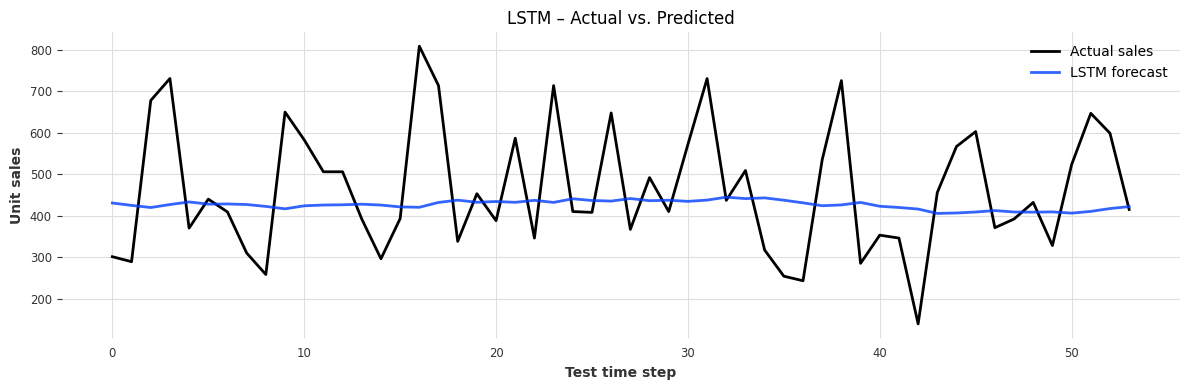

In [ ]:
# ------------------------------------------------------------------
# 5. Plot actual vs. forecast
# ------------------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(y_true, label="Actual sales", linewidth=2)
plt.plot(y_pred, label="LSTM forecast", linewidth=2, alpha=0.8)
plt.title("LSTM – Actual vs. Predicted")
plt.xlabel("Test time step")
plt.ylabel("Unit sales")
plt.legend()
plt.tight_layout()
plt.show()

- Probieren Sie es selbst aus! Machen Sie das LSTM intelligenter
Das aktuelle Modell kann Nachfragespitzen nur schwer vorhersagen, da es nur vergangene Verkäufe berücksichtigt. Ihre Aufgabe: Geben Sie ihm mehr Kontext und mehr Leistung.
  - Objektiv
Verbessern Sie die Fähigkeit des LSTM, Tage mit hoher Nachfrage vorherzusehen, indem Sie:
    - Hinzufügen neuer Eingabefunktionen (Kovariaten)
    - Optimieren wichtiger Parameter wie Verlaufsfenster und versteckte Einheiten
  - Schritt 1: Kovariaten hinzufügen
Fügen Sie Funktionen hinzu, die dem Modell dabei helfen können, einen bevorstehenden Spitzenwert zu erkennen. Beginnen Sie mit:
    - Kalender: day_of_week, is_weekend, month,week_of_year
    - is_holiday: from holiday_events.csv
    - Lag-/Rolling-Statistiken
  - 📌 Aktualisieren Sie Ihre Trainingsdaten, um diese Funktionen einzubeziehen. Stellen Sie sicher, dass sich die Form Ihrer LSTM-Eingabe entsprechend ändert.
  - Schritt 2: LSTM-Parameter optimieren
  Ändern Sie die Architektur- und Trainingseinstellungen:
    - Eingabefenstergröße : Versuchen Sie 30, 60, oder 90Zeitschritte
    - Modellkapazität : Erhöhen Sie auf 128Einheiten oder stapeln Sie 2LSTM-Schichten
    - Verlustfunktion : Tauschen Sie MAE gegen einen Quantilverlust oder Poisson- Verlust (falls unterstützt)
    - Stapeln Sie mehr LSTM-Schichten
💡 Tipp: Konzentrieren Sie sich darauf, ob das Modell genauer auf Spitzen reagiert. Selbst Teilerfolge sind ein Fortschritt!

Epoch 1/50
8/8 - 6s - 770ms/step - loss: 0.0293 - val_loss: 0.0317
Epoch 2/50
8/8 - 1s - 110ms/step - loss: 0.0133 - val_loss: 0.0233
Epoch 3/50
8/8 - 1s - 160ms/step - loss: 0.0111 - val_loss: 0.0219
Epoch 4/50
8/8 - 1s - 113ms/step - loss: 0.0098 - val_loss: 0.0205
Epoch 5/50
8/8 - 1s - 158ms/step - loss: 0.0090 - val_loss: 0.0204
Epoch 6/50
8/8 - 2s - 199ms/step - loss: 0.0096 - val_loss: 0.0209
Epoch 7/50
8/8 - 2s - 201ms/step - loss: 0.0093 - val_loss: 0.0203
Epoch 8/50
8/8 - 2s - 206ms/step - loss: 0.0095 - val_loss: 0.0196
Epoch 9/50
8/8 - 2s - 223ms/step - loss: 0.0090 - val_loss: 0.0209
Epoch 10/50
8/8 - 2s - 231ms/step - loss: 0.0093 - val_loss: 0.0192
Epoch 11/50
8/8 - 1s - 118ms/step - loss: 0.0093 - val_loss: 0.0200
Epoch 12/50
8/8 - 1s - 148ms/step - loss: 0.0092 - val_loss: 0.0212
Epoch 13/50
8/8 - 1s - 110ms/step - loss: 0.0097 - val_loss: 0.0195
Epoch 14/50
8/8 - 1s - 145ms/step - loss: 0.0083 - val_loss: 0.0198
Epoch 15/50
8/8 - 2s - 237ms/step - loss: 0.0082 - val_lo

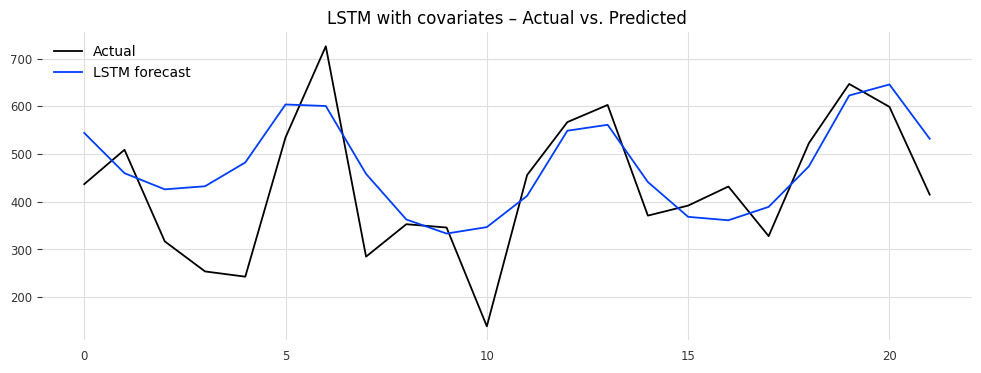

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.losses import Huber        # smoother than MAE

# ------------------------------------------------------------
# 0. Merge raw sales with covariates
# ------------------------------------------------------------
df = df_filtered.copy()                           # <— your main sales DF here
holiday_df = df_holiday_events[['date']]          # <— holiday_events.csv
#df["onpromotion"] = df["onpromotion"].fillna(0)   # 0/1 already

# ----- calendar features
df["day_of_week"]  = df.index.dayofweek
df["is_weekend"]   = df["day_of_week"].isin([5,6]).astype(int)
df["month"]        = df.index.month
df["week_of_year"] = df.index.isocalendar().week.astype(int)
df["is_holiday"]   = df.index.isin(holiday_df["date"]).astype(int)

# ----- lag / rolling stats (sales column = unit_sales)
df["lag_7"]        = df["unit_sales"].shift(7)
df["roll_mean_7"]  = df["unit_sales"].shift(1).rolling(7).mean()
df.dropna(inplace=True)                           # drop the first 7 rows

# ------------------------------------------------------------
# 1. Train / test split (time-based) and scaling
# ------------------------------------------------------------
feature_cols = ["unit_sales","day_of_week","is_weekend",
                "month","week_of_year","is_holiday","lag_7","roll_mean_7"]
data = df[feature_cols].values

cut = int(len(data)*0.8)
train_raw, test_raw = data[:cut], data[cut:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

# ------------------------------------------------------------
# 2. Turn scaled array into sliding windows
# ------------------------------------------------------------
SEQ_LEN = 60              # try 30 or 90 later

def make_seq(arr, n):
    X, y = [], []
    for i in range(len(arr)-n):
        X.append(arr[i:i+n, :])
        y.append(arr[i+n, 0])            # next-day sales (col 0)
    return np.array(X), np.array(y)

X_train, y_train = make_seq(train_scaled, SEQ_LEN)
X_test,  y_test  = make_seq(test_scaled,  SEQ_LEN)

# ------------------------------------------------------------
# 3. Two-layer LSTM  (128 → 64)  + Huber loss
# ------------------------------------------------------------
model = Sequential([
    LSTM(128, return_sequences=True,
         input_shape=(SEQ_LEN, len(feature_cols))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss=Huber(delta=1.0))

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=2)

# ------------------------------------------------------------
# 4. Forecast, inverse-scale, plot
# ------------------------------------------------------------
pred_scaled = model.predict(X_test).flatten()

# create dummy arrays so inverse_transform re-uses original scaling
tmp_pred = np.zeros((len(pred_scaled), len(feature_cols)))
tmp_true = np.zeros_like(tmp_pred)
tmp_pred[:,0] = pred_scaled
tmp_true[:,0] = y_test

y_pred = scaler.inverse_transform(tmp_pred)[:,0]
y_true = scaler.inverse_transform(tmp_true)[:,0]

mae = mean_absolute_error(y_true, y_pred)
print(f"Test MAE = {mae:.2f}")

plt.figure(figsize=(12,4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="LSTM forecast")
plt.title("LSTM with covariates – Actual vs. Predicted")
plt.legend(); plt.show()


## Um es zusammenzufassen!
In dieser Lektion haben wir die Grundlagen neuronaler Netze (NNs) , rekurrenter neuronaler Netze (RNNs) und LSTMs erkundet und LSTMs auf die Zeitreihenprognose angewendet. Sie fragen sich wahrscheinlich, ob es eine bessere Möglichkeit gibt, die Leistung von Modellen zu vergleichen, als sich viele Zeitreihendiagramme anzusehen. Auf jeden Fall! In der nächsten Woche besprechen wir die Modellbewertung und typische Metriken, die bei der Bewertung von Zeitreihenmodellen verwendet werden. Bis dahin haben Sie Zeit, die erlernten Modelle anhand des Datensatzes Ihres Projekts für diese Einheit zu trainieren.
Das Colab-Notizbuch mit dem in dieser Lektion verwendeten Code finden Sie hier .
Sie haben Lesezugriff auf die Notizbücher. Um sie auszuführen und zu ändern, kopieren Sie sie in Ihren Google Drive-Speicher.

## 💡Übung
Für dasselbe Geschäft, aber einen anderen Artikel ( 103665 ), und befolgen Sie dieselben Schritte.

---